In [34]:
%load_ext autoreload
%autoreload 2
import importlib
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scycle as cc
import scvelo as sv
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from elpigraph_ps_tools import *
from sica.base import StabilizedICA
import pandas as pd
import elpigraph

from scycle.preprocess import prep_pooling
from scycle.tools import dimensionality_reduction, enrich_components, principal_circle

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy
viridis = cm.get_cmap('viridis', 100)

def _get_node_median_counts(gexp, partition):
    prt = partition
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    node_median_counts = []
    size_counts = []
    for p in range(npart):
        sidx = np.where(partition == p)[0] # sample index
        if len(sidx)>0:
            totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
            median = np.median(totals) # median counts for samples in group
            median = int(median)
            node_median_counts.append(median)
            size_counts.append(len(totals))
        else:
            node_median_counts.append(0)
    node_median_counts = np.array(node_median_counts)    
    size_counts = np.array(size_counts)    
    return node_median_counts, new_gexp, size_counts

def _get_node_median_counts_from_feature(adata,feature,partition):
    prt = partition
    npart = np.max(prt)+1
    node_median_counts = []
    size_counts = []
    counts = np.array(adata.obs[feature])
    for p in range(npart):
        sidx = np.where(partition == p)[0] # sample index
        if len(sidx)>0:
            totals = counts[sidx] # total counts per sample in group
            median = np.median(totals) # median counts for samples in group
            median = int(median)
            node_median_counts.append(median)
            size_counts.append(len(totals))
        else:
            node_median_counts.append(0)
            size_counts.append(0)
    node_median_counts = np.array(node_median_counts)    
    size_counts = np.array(size_counts)
    return node_median_counts, size_counts



def renormalize_matrix_by_partition_smoothed(gexp, partition, traj, smoothing_factor=0.1,plot=False, partition_assignment=None,piecewise_linear=-1):
    npart = np.max(partition)+1
    node_median_counts, new_gexp,_ = _get_node_median_counts(gexp,partition)
    
    traj = np.array(traj)
    max_count = np.max(node_median_counts)
    node_median_counts_ord = node_median_counts[traj]
    node_median_counts_ord = node_median_counts_ord/max_count
    
    x = np.linspace(0,npart-1,npart)
    # correct for the presence of empty partitions
    irx_big_Vals = np.where(node_median_counts_ord>0.1)[0]
    x_corr = x[irx_big_Vals]
    node_median_counts_ord_corr = node_median_counts_ord[irx_big_Vals]
    
    if piecewise_linear<=0:
        # create cyclic borders
        x_corr = np.concatenate([x_corr-npart,x_corr,x_corr+npart],axis=0)
        node_median_counts_ord_corr = np.concatenate([node_median_counts_ord_corr,node_median_counts_ord_corr,node_median_counts_ord_corr],axis=0)
        curv_spl = UnivariateSpline(x_corr,node_median_counts_ord_corr,s=smoothing_factor,k=3)
        smoothed_node_counts_ord = curv_spl(x)
        smoothed_node_counts_ord_1 = curv_spl(x-npart)
        smoothed_node_counts_ord_2 = curv_spl(x+npart)
    else:
        x_final,y_final = piecewiselinear_readcounts_grid(x_corr,node_median_counts_ord_corr,number_of_segments=piecewise_linear)
        x_corr = np.concatenate([x_corr-npart,x_corr,x_corr+npart],axis=0)
        node_median_counts_ord_corr = np.concatenate([node_median_counts_ord_corr,node_median_counts_ord_corr,node_median_counts_ord_corr],axis=0)        
        y_final = np.array(y_final)
        smoothed_node_counts_ord = y_final
        smoothed_node_counts_ord_1 = y_final
        smoothed_node_counts_ord_2 = y_final

    smoothed_node_counts = np.zeros(npart)
    for i in traj:
        smoothed_node_counts[traj[i]] = smoothed_node_counts_ord[i]*max_count
    if plot:
        plt.figure(figsize=(10,3))
        #fig, axes = plt.subplots(nrows=1, ncols=2)
        #fig.tight_layout()
        plt.subplot(1,2,1)
        plt.plot(x_corr,node_median_counts_ord_corr,'ko')
        plt.plot(x,smoothed_node_counts_ord,'r-',linewidth=3)
        plt.plot(x-npart,smoothed_node_counts_ord_1,'r-',linewidth=3)
        plt.plot(x+npart,smoothed_node_counts_ord_2,'r-',linewidth=3)
        plt.plot([0,0],[0,1],'k--')
        plt.plot([npart-1,npart-1],[0,1],'k--')
        plt.xlabel('Pseudotime')
        plt.ylabel('Local median library size')
        plt.subplot(1,2,2)
        plt.plot(node_median_counts_ord[irx_big_Vals],smoothed_node_counts_ord[irx_big_Vals],'ko')
        plt.xlabel('Real median library size')
        plt.ylabel('Smoothed median library size')        
        plt.show()        
    
    for p in range(npart):
        sidx = np.where(partition == p)[0] 
        totals = np.sum(gexp[sidx,:], axis = 1)
        smoothed_median = smoothed_node_counts[p]
        if partition_assignment is not None:
            sidx = np.where(partition_assignment == p)[0] 
            totals = np.sum(gexp[sidx,:], axis = 1)
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * smoothed_median
        
    return new_gexp
    

def renormalize_by_partition_simplified_smoothed(adata, partition, traj, verbose = True, smoothing_factor=0.1, plot=False, partition_assignment=None,piecewise_linear=-1):
    old_totals = adata.obs['total_counts']
    adata.X = renormalize_matrix_by_partition_smoothed(adata.X, partition, traj,  smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment,piecewise_linear=piecewise_linear)
    if 'matrix' in adata.layers:
        adata.layers['matrix'] = renormalize_matrix_by_partition_smoothed(_get_nd_array(adata.layers['matrix']),partition, traj,  smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment,piecewise_linear=piecewise_linear)
    if 'spliced' in adata.layers:
        adata.layers['spliced'] = renormalize_matrix_by_partition_smoothed(_get_nd_array(adata.layers['spliced']),partition, traj, smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment,piecewise_linear=piecewise_linear)
    if 'unspliced' in adata.layers:
        adata.layers['unspliced'] = renormalize_matrix_by_partition_smoothed(_get_nd_array(adata.layers['unspliced']),partition, traj, smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment,piecewise_linear=piecewise_linear)
    adata.obs['total_counts'] = np.sum(adata.X, axis = 1)
    adata.obs['total_counts_raw'] = old_totals


def renormalize_matrix_by_partition(gexp, partition):
    prt = partition
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    for p in range(npart):
        sidx = np.where(partition == p)[0] # sample index
        totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
        median = np.median(totals) # median counts for samples in group
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * median
    return new_gexp
    

def renormalize_by_partition_simplified(adata, partition, verbose = True):
    old_totals = adata.obs['total_counts']
    adata.X = renormalize_matrix_by_partition(adata.X, partition)
    if 'matrix' in adata.layers:
        adata.layers['matrix'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['matrix']),partition)
    if 'spliced' in adata.layers:
        adata.layers['spliced'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['spliced']),partition)
    if 'unspliced' in adata.layers:
        adata.layers['unspliced'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['unspliced']),partition)
    adata.obs['total_counts'] = np.sum(adata.X, axis = 1)
    adata.obs['total_counts_raw'] = old_totals

    
def calc_scores(anndata,signature_dict,convert_to_decimal_log=True):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        if convert_to_decimal_log:
            matrix_sel/=np.log(10)
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def _smooth_adata_by_pooling(adata, X_embed, n_neighbours=10, copy=False):
    # adata_pooled = adata.copy if copy else adata
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)
    adata.X = _smooth_matrix_by_pooling(_get_nd_array(adata.X), indices)
    if "matrix" in adata.layers:
        adata.layers["matrix"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["matrix"]), indices
        )
    if "spliced" in adata.layers:
        adata.layers["spliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["spliced"]), indices
        )
    if "unspliced" in adata.layers:
        adata.layers["unspliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["unspliced"]), indices
        )

    adata.uns["scycle"] = True


def _smooth_matrix_by_pooling(matrix, indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i, :] = np.mean(matrix[indices[i], :], axis=0)
    return matrix_pooled


def _get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]



def compute_principal_curve_from_circle(X,n_nodes=30,Mu=0.1,Lambda=0.01, produceTree=False):
    egr = elpigraph.computeElasticPrincipalCircle(X,int(n_nodes/2),Mu=Mu)
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    partition_, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X**2,axis=1,keepdims=1))
    node_sizes = np.array([len(np.where(partition_==i)[0]) for i in range(nodep.shape[0])])
    node_min = np.argmin(node_sizes)
    edges_open = edges.copy()
    k = 0
    starting_node = -1
    while k<edges_open.shape[0]:
        e = edges_open[k,:]
        if (e[0]==node_min)|(e[1]==node_min):
            edges_open = np.delete(edges_open,k,axis=0)
            if e[0]==node_min:
                starting_node = e[1]
            if e[1]==node_min:
                starting_node = e[0]
        else:
            k = k+1
    nodep_open = np.delete(nodep,node_min,axis=0)
    if starting_node>node_min:
        starting_node = starting_node-1
    for e in edges_open:
        if e[0]>node_min:
            e[0]=e[0]-1
        if e[1]>node_min:
            e[1]=e[1]-1
    if produceTree:
        egrl = elpigraph.computeElasticPrincipalTree(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    else:
        egrl = elpigraph.computeElasticPrincipalCurve(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    return egrl, starting_node

def subtract_cell_cycle_trajectory(X,partition):
    points = range(X.shape[0])
    r2scores = []
    X1 = X[points,:]
    X_ro = np.zeros((X.shape[0],X.shape[1]))
    partition_points = partition[points]
    inds = {}
    for k in range(len(partition_points)):
        j = partition_points[k][0]
        if not j in inds:
            inds[j] = [k]
        else:
            inds[j].append(k)
    XT = X1.T
    for j in range(X1.shape[0]):
        k = partition_points[j][0]
        ind = np.array(inds[k])
        X_ro[j,:] = (XT[:,j] - np.mean(XT[:,ind],axis=1)).T
    residue_matrix = X1 - X_ro
    residues_var = np.var(residue_matrix,axis=0)
    vrs = np.var(X1,axis=0)
    r2scores = residues_var/vrs
    return X_ro, residue_matrix, r2scores

from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks


def calc_curvature(nodep,smoothing_factor=10):
    splines = []
    derivs = []
    for i in range(nodep.shape[1]):
        xv = np.linspace(0,nodep.shape[0]-1,nodep.shape[0])
        yv = nodep[:,i]
        #xv = np.array([-1]+list(xv)+[xv[-1]+1])
        #yv = np.array([2*yv[0]-yv[1]]+list(yv)+[2*yv[-1]-yv[-2]])
        #plt.plot(xv,yv,'-o')
        spline = UnivariateSpline(xv,yv,s=0,k=3)
        splines.append(spline)
        derivs.append(spline.derivative(n=2))
    n_points = nodep.shape[0]
    curv = np.zeros(nodep.shape[0])
    x = np.linspace(0,nodep.shape[0]-1,n_points)
    temp = np.zeros((n_points,nodep.shape[1]))
    print(temp.shape)
    for i in range(len(derivs)):
        temp[:,i] = derivs[i](x)
    curv = np.sqrt(np.sum(temp**2,axis=1))
    curv_spl = UnivariateSpline(x,curv,s=np.var(curv)*smoothing_factor,k=3)
    return x, curv_spl(x), splines


def find_nonproliferative_cells_from_pt_clustering(adata,number_of_nodes=50):
    X = adata.X
    X_elpigraph_training = adata.obs[['S-phase','G2-M']].to_numpy().astype(np.float64)
    egr, starting_node = compute_principal_curve_from_circle(X_elpigraph_training,
                                                             n_nodes=number_of_nodes,
                                                             Lambda=0.0001,
                                                            produceTree=True)
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    clusters = partition_data_by_tree_branches(X_elpigraph_training,egr[0])
    adata.obs['tree_clusters'] = clusters
    all_markers = adata.uns['S-phase_genes']+adata.uns['G2-M_genes']
    Xccm = adata[:,list(set(all_markers)&set(adata.var_names))].X
    cc_score = np.array(list(np.mean(Xccm,axis=1)))
    cluster_labels = list(set(clusters))
    cluster_prolif_levels = np.empty(cc_score.shape)
    cluster_prolif_levels_percluster = np.empty(len(cluster_labels))
    for i,clb in enumerate(cluster_labels):
        cluster_prolif_levels_percluster[i] = np.mean(cc_score[clusters==clb])
        cluster_prolif_levels[clusters==clb] = cluster_prolif_levels_percluster[i]
    adata.obs['cluster_prolif_levels'] = cluster_prolif_levels
    #sc.pl.scatter(adata,x='S-phase',y='G2-M',color='cluster_prolif_levels')
    ind_cluster_nonprolif = np.argmin(cluster_prolif_levels_percluster)
    ind_prolif = clusters!=ind_cluster_nonprolif
    adata.obs['proliferating'] = ind_prolif
    print('Fraction of non-proliferating cells:',1-np.sum(adata.obs['proliferating'])/len(adata))


def find_nonproliferative_cells(adata,estimation_fraction_nonproliferating_cells=0.3, 
                                number_of_nodes=30,max_number_of_iterations = 20,
                               number_of_sigmas=3.0,Mu=1.0):
    all_markers = list(adata.uns['S-phase_genes'])+list(adata.uns['G2-M_genes'])
    Xccm = adata[:,list(set(all_markers)&set(adata.var_names))].X
    cc_score = np.array(list(np.mean(Xccm,axis=1)))

    ind_sorted_prolif = np.argsort(cc_score)
    ind_nonprolif = ind_sorted_prolif[0:int(len(adata)*estimation_fraction_nonproliferating_cells)]
    adata.obs['proliferating'] = np.empty(len(adata)).astype(np.int)
    adata.obs['proliferating'][:] = 1
    adata.obs['proliferating'][ind_nonprolif] = 0
    
    sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

    fraction_nonprolif_old = estimation_fraction_nonproliferating_cells

    for i in range(max_number_of_iterations):
        X_elpigraph_training = adata.obs[['S-phase','G2-M']].to_numpy().astype(np.float64)
        u = X_elpigraph_training.copy()
        ind_prolif = np.where(np.array(adata.obs['proliferating'])==1)[0]        
        X_elpigraph_training = X_elpigraph_training[ind_prolif,:]

        egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,
                                                      Mu=Mu,drawPCAView=False,verbose=False)
        partition, dists = elpigraph.src.core.PartitionData(X = u, NodePositions = egr[0]['NodePositions'], 
                                                                MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                                SquaredX = np.sum(u**2,axis=1,keepdims=1))

        mndist = np.mean(dists[ind_prolif])
        #plt.hist(dists,bins=100)
        #plt.show()
        #plt.hist(dists[ind_prolif],bins=100)
        #plt.show()        
        intervaldist = np.std(dists[ind_prolif])*number_of_sigmas
        tt1 = np.array(1-adata.obs['proliferating'])
        tt2 = np.zeros(len(tt1)).astype(np.int)
        for k,d in enumerate(dists):
            if d>mndist+intervaldist:
                tt2[k] = 1
        nonprolif_new = np.array(tt1) * np.array(tt2)
        adata.obs['proliferating'] = 1-nonprolif_new
        #adata.obs['dists'] = dists
        #sc.pl.scatter(adata,x='S-phase',y='G2-M',color='dists')
        fraction_nonprolif = 1-np.sum(adata.obs['proliferating'])/len(adata)
        print('\n\n===========\nIteration',i,'Fraction of non-proliferating cells:',fraction_nonprolif,'\n==============\n\n\n')    
        if np.abs(fraction_nonprolif-fraction_nonprolif_old)<0.01:
            break
        fraction_nonprolif_old = fraction_nonprolif
        

from scipy.stats import median_absolute_deviation
from scipy.stats import norm
import scipy
from scipy import stats 
from scipy.stats import median_absolute_deviation
from scipy.stats import norm
from sklearn.neighbors import NearestCentroid


def _compute_ica(adata,thr=2.0):
    adata.uns["scycle"] = {}
    cc.tl.dimensionality_reduction(adata,method='ica')
    signature_dict = {}
    adata.uns['cc_genes'] = []
    if 'G1-S' in adata.uns['scycle']['find_cc_components']['indices']:
        idx_g1s = adata.uns['scycle']['find_cc_components']['indices']['G1-S']
        adata.uns['S-phase_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g1s,:]>thr])
        signature_dict['S-phase'] = adata.uns['S-phase_genes']
        adata.uns['cc_genes'] = list(set(adata.uns['cc_genes'])|set(adata.uns['S-phase_genes']))
    if 'G2-M' in adata.uns['scycle']['find_cc_components']['indices']:        
        idx_g2m = adata.uns['scycle']['find_cc_components']['indices']['G2-M']
        adata.uns['G2-M_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m,:]>thr])
        signature_dict['G2-M'] = adata.uns['G2-M_genes']        
        adata.uns['cc_genes'] = list(set(adata.uns['cc_genes'])|set(adata.uns['G2-M_genes']))
    if 'G2-M-' in adata.uns['scycle']['find_cc_components']['indices']:                
        idx_g2m_inh = adata.uns['scycle']['find_cc_components']['indices']['G2-M-']
        adata.uns['G2-M_INH_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m_inh,:]>thr])
        signature_dict['G2-M-'] = adata.uns['G2-M_INH_genes']                
        adata.uns['cc_genes'] = list(set(adata.uns['cc_genes'])|set(adata.uns['G2-M_INH_genes']))
    if 'Histone' in adata.uns['scycle']['find_cc_components']['indices']:                        
        idx_histone = adata.uns['scycle']['find_cc_components']['indices']['Histone']
        adata.uns['Histone_IC_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_histone,:]>thr])
        signature_dict['Histone_IC'] = adata.uns['Histone_IC_genes']        
        adata.uns['cc_genes'] = list(set(adata.uns['cc_genes'])|set(adata.uns['Histone_IC_genes']))
    sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
    ind_genes2k = np.where(adata.var['highly_variable'])[0]
    adata2k = adata[:,ind_genes2k]
    scores_dic = calc_scores(adata2k,signature_dict)
    for score in scores_dic:
        adata.obs[score] = scores_dic[score]
    adata.varm['P_dimRed'] = adata.uns['dimRed'].S_.T
    adata.uns['dimRed'] = None
    
def _compute_velocity(adata):
    sv.pp.moments(adata)
    sv.tl.velocity(adata, mode='stochastic')
    sv.tl.velocity_graph(adata)
    
def _visualize_velocity(adata):    
    sv.tl.velocity_graph(adata)
    sv.pl.velocity_embedding(adata, basis='pca',components='1,2', color='total_counts', size=100, alpha=0.5,perc=[2,98],
                         arrow_size=1,dpi=300,arrow_length=10) 
    
def _compute_principal_circle(adata,number_of_nodes=30,n_components = 30,Mu=0.2):
    #driving_feature = np.array(adata_orig[adata.uns['ind_samples']].obs['total_counts'])
    #driving_feature_weight = 1.0
    #egr, partition, X, Xp = _compute_principal_circle(adata,number_of_nodes=40,
    #                                                  driving_feature=driving_feature,driving_feature_weight=0.1)

    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    #driving_feature = driving_feature[adata.obs[np.where(adata.obs['proliferating']==1)[0]]]

    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    #X_pca = adata.obsm['X_pca'].astype(np.float64)
    X_elpigraph_training = u.astype(np.float64)
    #std = np.std(X_elpigraph_training)
    #driving_feature = stats.zscore(driving_feature)*std*driving_feature_weight
    #driving_feature = driving_feature.reshape(-1,1)
    #X_elpigraph_training = np.concatenate([X_elpigraph_training,driving_feature],axis=1)
    #print('std=',std)
    #print('std df=',np.std(driving_feature))

    #print(X_elpigraph_training.shape)
    egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,Mu=Mu)
    partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    Xp = (X-mn_prolif)@v
    #number_of_driving_features = driving_feature.shape[1]
    #node_positions_reduced = egr[0]['NodePositions'][:,:-number_of_driving_features]
    nodep = egr[0]['NodePositions']
    partition, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = nodep, 
                                                           MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                           SquaredX = np.sum(Xp**2,axis=1,keepdims=1))

    #nodep = egr[0]['NodePositions'][:,:-number_of_driving_features]
    #edges = egr[0]['Edges'][0]
    #X_elpigraph_training = X_elpigraph_training[:,:-number_of_driving_features]
    #egr[0]['NodePositions'] = nodep
    return egr, partition, X_elpigraph_training, Xp


def _compute_principal_curve(adata,number_of_nodes=30, Mu=0.3, Lambda=0.001,n_components=30):
    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]

    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    #X_pca = adata.obsm['X_pca'].astype(np.float64)
    
    adata.varm['pc_components_elpigraph'] = v
    adata.varm['mean_point_elpigraph'] = mn_prolif
    
    X_elpigraph_training = u.astype(np.float64)

    egr, starting_node = compute_principal_curve_from_circle(X_elpigraph_training,
                                                             n_nodes=number_of_nodes,
                                                            produceTree=False,Mu=Mu,Lambda=Lambda)

    partition_, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    Xp = (X-mn_prolif)@v
    partition_, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(Xp**2,axis=1,keepdims=1))

    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    return egr, partition_, starting_node,X_elpigraph_training, Xp

def _renormalize(adata,adata_orig,egr,partition,PseudoTimeTraj=None,smoothing_factor=0.1,pooling=True,smoothed=True,plot=True,reassignment_thresh=3.0,max_number_of_iterations=3,colors=None,piecewise_linear=-1):
    ind_samples = adata.uns['ind_samples']
    ind_genes = adata.uns['ind_genes']
    adata_renorm = adata_orig.copy()[ind_samples,:]
    
    adata.uns['jumping_points'] = []
        
    if smoothed:
        points = PseudoTimeTraj[0]['Points']
        pst = PseudoTimeTraj[0]['Pseudotime']
        traj = PseudoTimeTraj[0]['Trajectory']
        id_points = np.zeros(len(points)).astype(np.int32)
        for i,j in enumerate(points):
            id_points[j] = int(i)
        x = pst[id_points]
        vals = adata_renorm.obs['total_counts']
        partition_assignment,jumping_points = _recompute_partition_by_pseudotime(partition,x,vals,traj,thresh=reassignment_thresh,max_number_of_iterations=max_number_of_iterations)
        adata.uns['jumping_points'] = jumping_points
        
        #node_median_counts,_,_ = _get_node_median_counts(adata_renorm.X, partition)
        node_median_counts,_ = _get_node_median_counts_from_feature(adata_renorm,'total_counts',partition_assignment)
        
        if plot:
            plt.figure(figsize=(13,4))
            id_points = np.zeros(len(pst)).astype(np.int32)
            for i,j in enumerate(points):
                id_points[j] = int(i)
            x = pst[id_points]
            if colors is None:
                colors = []
                for k in range(len(node_median_counts)):
                    color = [np.random.random(),np.random.random(),np.random.random()]
                    while np.mean(color)>0.9:
                        color = [np.random.random(),np.random.random(),np.random.random()]
                    colors.append(color)
            for k in range(len(node_median_counts)):
                idx = np.where(partition_assignment==k)[0]
                color = colors[k]
                plt.plot(x[idx],vals[idx],'ko',markersize=5,c=colors[k])
            #plt.plot(x[jumping_points],vals[jumping_points],'rx',markersize=10,c=colors[k])
            plt.plot(node_median_counts[traj],'ro',linewidth=5)
            plt.show()
        
        #renormalize_by_partition_simplified_smoothed(adata_renorm,partition,traj,smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment)
        renormalize_by_partition_simplified_smoothed(adata_renorm,partition,traj,smoothing_factor=smoothing_factor,plot=plot,partition_assignment=partition_assignment,piecewise_linear=piecewise_linear)
    else:
        renormalize_by_partition_simplified(adata_renorm,partition)
    
    adata_renorm_proc = adata_renorm.copy()
    sc.pp.calculate_qc_metrics(adata_renorm_proc, percent_top=None, log1p=False, inplace=True)
    sc.pp.log1p(adata_renorm_proc)
    adata_renorm_proc = adata_renorm_proc[:,ind_genes]
    sc.tl.pca(adata_renorm_proc,n_comps=30)
    X_pca = adata_renorm_proc.obsm['X_pca']
    adata_work = adata_renorm.copy()
    if pooling:
        _smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=10)
    adata_renorm_proc = adata_work
    sc.pp.log1p(adata_renorm_proc)
    adata_renorm_proc = adata_renorm_proc[:,ind_genes]
    sc.tl.pca(adata_renorm_proc,n_comps=30)
    X_pca = adata_renorm_proc.obsm['X_pca']
    adata_renorm_proc.obs['proliferating'] = adata.obs['proliferating']
    adata_renorm_proc.uns['jumping_points'] = adata.uns['jumping_points']
    return adata_renorm,adata_renorm_proc

def _make_PCA_plot(adata, egr, n_components=30, delta=0.05,subsample=None,highlighted_nodes=None,figsize=(7.5,6.1), arrow_width=0.07, tc_name = 'total_counts_raw'):
    
    if not tc_name in adata.obs:
        tc_name = 'total_counts'
    tc = adata.obs[tc_name]
    tc = scipy.stats.mstats.winsorize(tc,limits=[0.1,0.1])
    tc = (tc-np.min(tc))/(np.max(tc)-np.min(tc))*100

    velocity_X = adata.layers['velocity']


    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T

    X_elpigraph_training = u

    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]

    mean_vector = np.mean(X_elpigraph_training,axis=0)
    nodep_full = np.matmul(v,nodep.T).T+mn_prolif
    adata.uns['NodePositions'] = nodep_full
    adata.uns['Edges'] = edges
    print(nodep_full.shape)

    #mn1 = np.mean(adata.X,axis=0)
    #pca = PCA(n_components=30)
    #u1 = pca.fit_transform(adata.X)
    #v1 = pca.components_.T
    
    mn1 = np.mean(nodep_full,axis=0)
    pca = PCA(n_components=30)
    u_nodes = pca.fit_transform(nodep_full)
    v1 = pca.components_.T
    
    u1 = (adata.X-mn1)@v1

    #nodep1 = np.matmul(nodep_full-mn1,v1)
    nodep1 = u_nodes

    xx = np.matmul(velocity_X,v1)
    n = adata.X.shape[0]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    
    if subsample is None:
        subsample = range(n)
    
    plt.scatter(u1[subsample,0],u1[subsample,1],c=adata.obs[tc_name][subsample],s=1)
    #plt.scatter(u[0:n,0],u[0:n,1],c='k',s=1)
    for i in subsample:
        x1 = u1[i,0:2]
        x2 = xx[i,0:2]*delta
        if adata.obs['proliferating'][i]:
            plt.arrow(x1[0],x1[1],x2[0],x2[1],width=arrow_width,color=viridis(int(tc[i])),edgecolor=(0,0,0))
        else:
            plt.arrow(x1[0],x1[1],x2[0],x2[1],width=arrow_width,color='grey',edgecolor=(0,0,0))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.axis('equal')
    plt.colorbar()
    #plt.axis('off')
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])
    for e in edges:
        plt.plot([nodep1[e[0],0],nodep1[e[1],0]],[nodep1[e[0],1],nodep1[e[1],1]],'r-',linewidth=5, alpha=0.5)
    if highlighted_nodes is not None:
        for k in highlighted_nodes:
            plt.plot(nodep1[k,0],nodep1[k,1],'ro',markersize=20, alpha=0.5)
        
    plt.savefig(dataset_name+'_PCA.png')
    #plt.show()
    return u1, u_nodes


def _make_G1SG2M_plot(adata, egr, n_components=30, delta=0.05, arrow_width=0.07, subsample=None,highlighted_nodes=None,figsize=(5,5),featurex=('S-phase_genes','S-phase'),featurey=('G2-M_genes','G2-M')):
    fig = plt.figure(figsize=figsize)
    X = adata.X

    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    mn_prolif = np.mean(X_prolif,axis=0)    
    
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    
    mn = mn_prolif
    
    tc_name = 'total_counts_raw'
    if not tc_name in adata.obs:
        tc_name = 'total_counts'
    tc = adata.obs[tc_name]
    tc = scipy.stats.mstats.winsorize(tc,limits=[0.1,0.1])
    tc = (tc-np.min(tc))/(np.max(tc)-np.min(tc))*100
    velocity_X = adata.layers['velocity']

    X1 = X + velocity_X*delta*1
    X2 = np.concatenate((X,X1),axis=0)
    adata_temp = anndata.AnnData(X = X2)
    adata_temp.obs_names = list(adata.obs_names)*2
    adata_temp.var_names = adata.var_names
    adata_temp.obs['total_counts'] = list(adata.obs['total_counts'])*2

    sc.pp.highly_variable_genes(adata_temp,n_top_genes=2001,n_bins=20)
    ind_genes2k = np.where(adata_temp.var['highly_variable'])[0]
    adata2k = adata_temp[:,ind_genes2k]
    signature_dict = {featurex[1]:adata.uns[featurex[0]],featurey[1]:adata.uns[featurey[0]]}
    scores_dic = calc_scores(adata_temp,signature_dict)
    for s in scores_dic:
        adata_temp.obs[s] = scores_dic[s]

    n = X.shape[0]

    x1 = adata_temp.obs[[featurex[1],featurey[1]]].to_numpy()[0:n]
    print(x1.shape)
    x2 = adata_temp.obs[[featurex[1],featurey[1]]].to_numpy()[n:2*n]

    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    
    n_nodes = nodep.shape[0]
    nodes_projection = np.zeros((n_nodes,2))
    node_real_coordinates = nodep@v.T+mn

    adata_nodes = anndata.AnnData(X = node_real_coordinates)
    adata_nodes.var_names = adata.var_names
    scores_dic_nodes = calc_scores(adata_nodes,signature_dict)
    for s in scores_dic_nodes:
        adata_nodes.obs[s] = scores_dic_nodes[s]

    #for i in range(n_nodes):
    #    nodes_projection[i,:] = np.mean(x1[np.where(partition==i)[0],:],axis=0)

    #cc.pp.score_cell_cycle(adata_temp)
    ax = fig.add_subplot(1,1,1)
    if subsample is None:
        subsample = range(n)
    ax.scatter(x1[subsample,0],x1[subsample,1],c=adata.obs['total_counts'][subsample],s=0.1)

    #plt.scatter(x1[:,0],x1[:,1],c='k',s=1)
    #plt.scatter(x2[:,0],x2[:,1],c='b',s=1)

    for i in subsample:
        p1 = x1[i,:]
        p2 = x2[i,:]-x1[i,:]
        if adata.obs['proliferating'][i]:
            plt.arrow(p1[0],p1[1],p2[0],p2[1],width=arrow_width,color=viridis(int(tc[i])),edgecolor=None)
        else:
            plt.arrow(p1[0],p1[1],p2[0],p2[1],width=arrow_width,color='grey',edgecolor=None)
        #plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k-')
    plt.xlabel(featurex[1]+' score')
    plt.ylabel(featurey[1]+' score')
    node_scores = adata_nodes.obs[[featurex[1],featurey[1]]].to_numpy()
    for e in edges:
        #plt.plot([nodes_projection[e[0],0],nodes_projection[e[1],0]],
        #         [nodes_projection[e[0],1],nodes_projection[e[1],1]],'b-',linewidth=10)
        plt.plot([node_scores[e[0],0],node_scores[e[1],0]],
                 [node_scores[e[0],1],node_scores[e[1],1]],'r-',linewidth=3,alpha=0.5)
    if highlighted_nodes is not None:
        for k in highlighted_nodes:
            plt.plot(node_scores[k,0],node_scores[k,1],'ro',markersize=15,alpha=0.5)
            

    #plt.axis('equal')
    #plt.axis('off')
    #plt.axis(fontsize=20)
    #ax.xaxis.get_major_ticks().label.set_fontsize(20) 
    #plt.savefig(dataset_name+'_G1S_G2M.png')
    #plt.show()    
    
def _compute_pseudotime(adata, gr, starting_node, Xp):
    traj = extract_trajectories(gr,starting_node,verbose=True)[0]
    if len(traj)==1:
        traj = extract_trajectories(gr,starting_node,verbose=True)[1]
    ProjStruct = project_on_tree(Xp,gr)
    PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
    points = PseudoTimeTraj[0]['Points'] 
    pst = PseudoTimeTraj[0]['Pseudotime']

    tcr = np.array(adata.obs['total_counts_raw'])
    corr = np.corrcoef(pst,tcr[points])[0,1]
    if corr<0:
        traj.reverse()
        PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
        points = PseudoTimeTraj[0]['Points'] 
        pst = PseudoTimeTraj[0]['Pseudotime']
        
    #plt.plot(pst,tcr[points],'k.')
        
    return traj, PseudoTimeTraj

def open_principal_circle(egr,X):
    nodep = egr['NodePositions']
    edges = egr['Edges'][0]
    partition_, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X**2,axis=1,keepdims=1))
    node_sizes = np.array([len(np.where(partition_==i)[0]) for i in range(nodep.shape[0])])
    node_min = np.argmin(node_sizes)
    edges_open = edges.copy()
    k = 0
    starting_node = -1
    print('node_min',node_min)
    #print(edges)
    while k<edges_open.shape[0]:
        e = edges_open[k,:]
        if (e[0]==node_min)|(e[1]==node_min):
            print('deleted',edges_open[k,:])
            edges_open = np.delete(edges_open,k,axis=0)
            if (e[0]==node_min):
                starting_node = e[0]
            else:
                starting_node = e[1]
            break
        else:
            k = k+1
    #nodep_open = np.delete(nodep,node_min,axis=0)
    if starting_node>node_min:
        starting_node = starting_node-1
    egr['NodePositions'] = nodep
    egr['Edges'] = (edges_open,)
    return egr, starting_node

def augment_data_with_RNA_velocity(adata,delta=0.05,n_components=10):
    velocity_X = adata.layers['velocity']
    x = adata.X
    print('x',x.shape)
    mn1 = np.mean(x,axis=0)
    pca = PCA(n_components=n_components)
    u1 = pca.fit_transform(x)
    print('u1',u1.shape)
    v1 = pca.components_.T
    print('v1',v1.shape)
    u2 = u1+np.matmul(velocity_X,v1)*delta
    print('u2',u2.shape)
    xx_full = np.matmul(u2,v1.T)+mn1
    return np.concatenate([x,xx_full],axis=0)

def _plot_gene_expression(adata,egr,PseudoTimeTraj,genes,colors,plot_legend=True):
    pst = PseudoTimeTraj[0]['Pseudotime']
    points = PseudoTimeTraj[0]['Points']
    traj = PseudoTimeTraj[0]['Trajectory']

    nodep = egr[0]['NodePositions']
    mn = adata.varm['mean_point_elpigraph']
    v = adata.varm['pc_components_elpigraph']

    node_real_coordinates = nodep@v.T+mn
    adata_nodes = anndata.AnnData(X = node_real_coordinates)
    adata_nodes.var_names = adata.var_names

    Xsel = adata[:,genes].X
    node_vals = adata_nodes[:,genes].X
    plot_relative = True
    if plot_relative:
        node_vals/=np.max(Xsel,axis=0)
        Xsel/=np.max(Xsel,axis=0)

    for i,g in enumerate(genes):
        plt.plot(pst,Xsel[points,i],colors[i]+'.',label=genes[i],alpha=0.1)
        plt.plot(range(node_vals.shape[0]),node_vals[traj,i],colors[i]+'-',linewidth=5)
    plt.ylabel('Relative gene\nexpression',fontsize=20)
    plt.xlabel('Pseudotime',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if plot_legend:
        plt.legend(fontsize=20)

def _plot_scores(adata,egr,PseudoTimeTraj,scores,score_dict,colors,plot_legend=True,plot_nodes=False):
    pst = PseudoTimeTraj[0]['Pseudotime']
    points = PseudoTimeTraj[0]['Points']
    traj = PseudoTimeTraj[0]['Trajectory']

    nodep = egr[0]['NodePositions']
    mn = adata.varm['mean_point_elpigraph']
    v = adata.varm['pc_components_elpigraph']

    node_real_coordinates = nodep@v.T+mn
    adata_nodes = anndata.AnnData(X = node_real_coordinates)
    adata_nodes.var_names = adata.var_names
    
    scores = calc_scores(adata_nodes,score_dict)

    for i,sc in enumerate(scores):
        plt.plot(pst,adata.obs[sc][points],colors[i]+'.',label=sc,alpha=0.1)
        if plot_nodes:
            plt.plot(range(node_real_coordinates.shape[0]),scores[sc][traj],colors[i]+'-',linewidth=5)
    plt.ylabel('Score value',fontsize=20)
    plt.xlabel('Pseudotime',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if plot_legend:
        plt.legend(fontsize=20)        
        
        
def _plot_curvature(adata,egr,PseudoTimeTraj,smoothing_factor=15,max_dimension=10,scale=1,normalize=True,colors=None):
    nodep = egr[0]['NodePositions']
    max_dimension = nodep.shape[1]
    traj = PseudoTimeTraj[0]['Trajectory']
    pst = PseudoTimeTraj[0]['Pseudotime']
    points = PseudoTimeTraj[0]['Points']
    gr = egr[0]
    curv = np.zeros(len(traj))
    nodep = gr['NodePositions']
    reduced_dimension = np.min([nodep.shape[1],max_dimension])
    x_curv, curv, splines = calc_curvature(nodep[traj,0:reduced_dimension],smoothing_factor=smoothing_factor)
    x_curv = x_curv[1:-1]
    curv = curv[1:-1]
    if normalize:
        curv = (curv-np.min(curv))/(np.max(curv)-np.min(curv))
    curvature_peaks = np.array(find_peaks(curv))[0]+1
    plt.plot(x_curv,scale*curv,'ko-',label='Curvature',linewidth=5,markersize=10)
    for i in range(curvature_peaks.shape[0]):
        plt.plot([curvature_peaks[i],curvature_peaks[i]],
                 [np.min(curv),scale*curv[int(curvature_peaks[i])]],
                 'k--',linewidth=1.5)
    plt.xlabel('Pseudotime',fontsize=40)
    plt.ylabel('Curvature',fontsize=40)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    return curvature_peaks

def _plot_trajectory(adata,egr,PseudoTimeTraj,curvature_peaks,i0=0,i1=1,draw_node_id=True):
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    traj = PseudoTimeTraj[0]['Trajectory']
    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    mn_prolif = np.mean(X_prolif,axis=0)
    pca = PCA(n_components=30)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    nodep_full = np.matmul(nodep,v.T)+mn_prolif
    print('node_full',nodep_full.shape)
    mn1 = np.mean(adata.X,axis=0)
    pca = PCA(n_components=30)
    u1 = pca.fit_transform(adata.X)
    v1 = pca.components_.T
    nodep1 = np.matmul(nodep_full-mn1,v1)
    plt.plot(u1[:,i0],u1[:,i1],'k.')
    for i in curvature_peaks:
        plt.plot(nodep1[traj[i],i0],nodep1[traj[i],i1],'ro',markersize=20)
    for num,i in enumerate(curvature_peaks):
        plt.plot(nodep1[traj[i],i0],nodep1[traj[i],i1],'ro',markersize=20)
        if draw_node_id:
            plt.text(nodep1[traj[i],i0],nodep1[traj[i],i1],str(num),fontsize=10,color='k')
    for e in edges:
        plt.plot([nodep1[e[0],i0],nodep1[e[1],i0]],[nodep1[e[0],i1],nodep1[e[1],i1]],'r-',linewidth=5)
    plt.xlabel('PC'+str(i0+1))
    plt.ylabel('PC'+str(i1+1))
    plt.axis('equal')

def _recompute_partition_by_pseudotime(partition,x_vals,y_vals,traj,thresh=3.0,max_number_of_iterations=10):
    jumping_points = set()
    n_part = np.max(partition)
    for itr in range(max_number_of_iterations):
        irx_jump_left = []
        irx_jump_right = []
        x = x_vals
        y = y_vals
        for k in range(np.max(partition)):
            idx = np.where(partition==k)[0]
            yp = y[idx]
            traj = np.array(traj)
            irx = np.where(traj==k)[0][0]
            m = np.median(yp)
            mad = median_absolute_deviation(yp)
            if irx>0:
                yp_before = y[np.where(partition==traj[irx-1])[0]]
                m_before = np.median(yp_before)
                mad_before = median_absolute_deviation(yp_before)     
            else:
                m_before = np.median(yp)
                mad_before = 1e-10
            if irx<np.max(partition)-1:
                yp_after = y[np.where(partition==traj[irx+1])[0]]    
                m_after = np.median(yp_after)
                mad_after = median_absolute_deviation(yp_after)    
            else:
                m_after = np.median(yp)
                mad_after = 1e-10
            df_befores = []
            dfs = []
            df_afters = []
            for v in yp:
                z_before = ((v-m_before)/mad_before)**2
                z = ((v-m)/mad)**2
                z_after = ((v-m_after)/mad_after)**2
                df_befores.append(z_before)
                dfs.append(z)
                df_afters.append(z_after)
            for i,z in enumerate(dfs):
                z_after = df_afters[i]
                z_before = df_befores[i]
                if (z_after<thresh)&(np.abs(np.abs(z)-np.abs(z_after))>thresh):
                    irx_jump_right.append(idx[i])
                if (z_before<thresh)&(np.abs(np.abs(z)-np.abs(z_before))>thresh):
                    irx_jump_left.append(idx[i])
        if (len(irx_jump_left)==0)&(len(irx_jump_right)==0):
            break
        irx_jump_left = np.array(irx_jump_left).astype(np.int)
        irx_jump_right = np.array(irx_jump_right).astype(np.int)
        
        # Now, let us find anomalously wide partitions
        widths = np.zeros(np.max(partition)+1)
        for k in range(np.max(partition)):
            idx = np.where(partition==k)[0]
            if len(idx)>0:
                widths[k] = median_absolute_deviation(y[idx])
            else:
                widths[k] = 0
        irx_outlier_width = np.where(widths>np.median(widths)+thresh*median_absolute_deviation(widths))[0]
        
        # Now, we split outlier partitions accordingly to the median counts of neighbouring partitions
        xs = stats.zscore(x)
        ys = stats.zscore(y)
        irx_subset_to_split = []
        indices = []
        medoids = []
        for k in range(np.max(partition)):
            idx = np.where(partition==k)[0]
            if k in irx_outlier_width:
                for i in idx:
                    irx_subset_to_split.append(i)
            else:
                is_neighbour_of_outlier = False
                for j in irx_outlier_width:
                    irx_k = np.where(traj==k)[0][0]
                    irx_j = np.where(traj==j)[0][0]
                    if np.abs(irx_k-irx_j)==1:
                        is_neighbour_of_outlier = True
                    if is_neighbour_of_outlier:
                        medoids.append([np.median(xs[idx]),np.median(ys[idx])])
                        indices.append(k)
                    if (irx_j==0)&(irx_k==n_part-1):
                        medoids.append([np.median(xs[np.where(partition==j)[0]]),np.median(ys[idx])])
                        indices.append(k)
                    if (irx_j==n_part-1)&(irx_k==0):
                        medoids.append([np.median(xs[np.where(partition==j)[0]]),np.median(ys[idx])])
                        indices.append(k)
                        
        irx_subset_to_split = np.array(irx_subset_to_split)
        #print('irx_subset_to_split=',irx_subset_to_split)
        #print('indices=',indices)
        medoids = np.array(medoids)
        if len(set(indices))<2:
            irx_subset_to_split = []
        if len(irx_subset_to_split)>0:
            xs = xs[irx_subset_to_split]
            ys = ys[irx_subset_to_split]
            xx = np.array([xs,ys]).T
            clf = NearestCentroid()
            clf.fit(medoids, indices)
            predicted = clf.predict(xx)        
        
        
        new_partition = partition.copy()
        for i in irx_jump_right:
            p = partition[i]
            irx = np.where(traj==p)[0][0]
            new_partition[i] = traj[irx+1]
            jumping_points.add(i)
        for i in irx_jump_left:
            p = partition[i]
            irx = np.where(traj==p)[0][0]
            new_partition[i] = traj[irx-1]
            jumping_points.add(i)
        for i in range(len(irx_subset_to_split)):
            new_partition[irx_subset_to_split[i]] = predicted[i]
            
        partition = new_partition
                
    return partition,np.array(list(jumping_points))

def _fix_boolean_field(adata,field):
    arr = np.array(adata.obs[field])
    adata.obs[field] = np.array(len(adata))
    n = 0
    for i,t in enumerate(arr):
        if (t=='True')|(t==True):
            adata.obs[field][i] = True
        else:
            adata.obs[field][i] = False
    print('Number of '+field+':',np.sum(adata.obs[field]))
    
def _plot_count_plot_by_partition(adata,partition,PseudoTimeTraj,field='total_counts',jumping_points=None,colors=None):
    points = PseudoTimeTraj[0]['Points']
    pst = PseudoTimeTraj[0]['Pseudotime']
    traj = np.array(PseudoTimeTraj[0]['Trajectory'])
    #print(traj)
    #print(type(traj))
    id_points = np.zeros(len(points)).astype(np.int32)
    for i,j in enumerate(points):
        id_points[j] = int(i)
    x = pst[id_points]
    vals = adata.obs[field]
    node_median_counts,_,_ = _get_node_median_counts(adata.X,partition)
    #colors = []
    plt.figure(figsize=(13,4))
    #for k in range(len(node_median_counts)):
        
    if colors is None:
        colors = []
        for k in range(len(node_median_counts)):
            color = [np.random.random(),np.random.random(),np.random.random()]
            while np.mean(color)>0.9:
                color = [np.random.random(),np.random.random(),np.random.random()]
            colors.append(color)
    for k in range(len(node_median_counts)):
        idx = np.where(partition==k)[0]
        color = colors[k]
        plt.plot(x[idx],vals[idx],'ko',markersize=5,c=colors[k])
        
        #color = [np.random.random(),np.random.random(),np.random.random()]
        #while np.mean(color)>0.9:
        #    color = [np.random.random(),np.random.random(),np.random.random()]
        #print('Color=',color,'pst=',np.where(traj==k)[0])
#        colors.append(color)
#    for k in range(len(node_median_counts)):
#        idx = np.where(partition==k)[0]
#        color = colors[k]
#        plt.plot(x[idx],vals[idx],'ko',markersize=5,c=colors[k])
    if jumping_points is not None:
        plt.plot(x[jumping_points],vals[jumping_points],'rx',markersize=5)
            
    plt.plot(node_median_counts[traj],'ro',linewidth=5)
    plt.show()
    return colors
    
def qc_preprocessing_pooling(adata_orig,n_comps=30,n_neighbours=10,n_top_genes=10000,min_count=10000,max_count=50000,mt_threshold=20):
    adata = adata_orig
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sv.pp.remove_duplicate_cells(adata)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
    inds2 = np.where(adata.obs['pct_counts_mt']<mt_threshold)
    print(len(inds1[0]),'samples pass the count filter')
    print(len(inds2[0]),' samples pass the mt filter')
    ind_samples = np.intersect1d(inds1[0],inds2[0])
    print('Samples selected',len(ind_samples))
    adata.uns['ind_samples'] = ind_samples
    adata = adata[ind_samples,:]
    sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata,n_top_genes=n_top_genes,n_bins=20)
    ind_genes = np.where(adata.var['highly_variable'])[0]
    adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=n_comps)
    X_pca = adata.obsm['X_pca']
    adata_work = adata_orig.copy()[ind_samples,:]
    _smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours)
    adata = adata_work
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
    sc.pp.log1p(adata)
    adata = adata[:,ind_genes]
    adata.uns['ind_genes'] = ind_genes
    sc.tl.pca(adata,n_comps=n_comps)
    X_pca = adata.obsm['X_pca']
    return adata

from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

def SegmentedLinearReg_function_(x,Xsolution,Ysolution):
    k = 0
    for i in range(len(Xsolution)-1):
        if (x>=Xsolution[i])&(x<Xsolution[i+1]):
            break
    b = (Ysolution[i+1]-Ysolution[i])/(Xsolution[i+1]-Xsolution[i])
    a = Ysolution[i] - b*Xsolution[i]
    return a+b*x

def SegmentedLinearReg_function(x,Xsolution,Ysolution):
    res = []
    for x_ in x:
        res.append(SegmentedLinearReg_function_(x_,Xsolution,Ysolution))
    return np.array(res)

def piecewiselinear_readcounts_grid(pseudotime,reads,number_of_segments=2):
    X = pseudotime
    Y = reads
    y_corr_diff = [Y[i]-Y[i+1] for i in range(len(Y)-1)]
    k = np.argmax(y_corr_diff)+1
    print(k)
    x_corr_rot = X.tolist()[k:]+X.tolist()[:k]
    y_corr_rot = Y.tolist()[k:]+Y.tolist()[:k]
    X = pseudotime
    Y = y_corr_rot
    initialBreakpoints = []
    for i in range(number_of_segments-1):
        initialBreakpoints.append(np.round(len(X)*(i+1)/number_of_segments))
    print(initialBreakpoints)
    Xsolution, Ysolution = SegmentedLinearReg(X, Y, initialBreakpoints )
    y_pwlf = SegmentedLinearReg_function(X,Xsolution,Ysolution)
    x_final = X
    y_final = y_pwlf.tolist()[-k:]+y_pwlf.tolist()[:-k]
    return x_final,y_final

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# File locations
folder = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/'
#folder = '/mnt/c/Datas/SingleCellTranscriptomics/U2OS/'
loom_folder = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/loom_files/'
#loom_folder = folder
dataset_name = 'CHLA9'
#dataset_name = 'u2os'

In [4]:
# Starting from loom file
file = loom_folder+dataset_name
adata = anndata.read_loom(file+'.loom')
print(adata)
adata.var_names_make_unique()
#adata.remove_duplicate_cells()
adata.X = adata.X.toarray()
adata.layers["matrix"] = adata.layers["matrix"].toarray()
adata.layers["spliced"] = adata.layers["spliced"].toarray()
adata.layers["unspliced"] = adata.layers["unspliced"].toarray()
#adata.obs['total_counts'] = adata.obs['TotalUMIs']
adata.obs['total_counts'] = np.sum(adata.X,axis=1)


#subsample if needed for testing
#adata = adata[1::5]

adata_orig = adata.copy()
adata_orig.obs['total_counts_raw'] = adata_orig.obs['total_counts']
adata.obs['total_counts_raw'] = adata_orig.obs['total_counts']

adata.write_h5ad(folder+dataset_name+'_orig.h5ad',compression='gzip')
#adata.write_h5ad(folder+dataset_name+'_orig_subsample.h5ad',compression='gzip')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'


... storing 'Accession' as categorical
... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


In [4]:
# start from here if needed from the h5ad file (e.g., from a subsample)

#adata_orig = sc.read_h5ad(folder+dataset_name+'_orig_subsample.h5ad')
print(adata_orig)

AnnData object with n_obs × n_vars = 1012 × 60662
    obs: 'TotalUMIs', 'total_counts', 'total_counts_raw'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'


... storing 'Accession' as categorical
... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


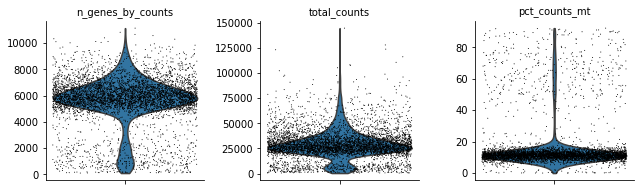

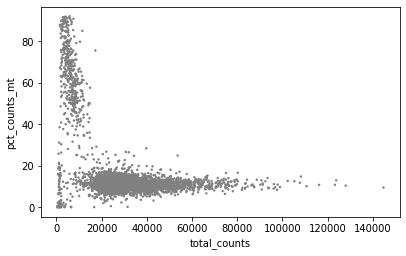

4214 samples pass the count filter
4599  samples pass the mt filter
Samples selected 4137


Trying to set attribute `.uns` of view, copying.


In [5]:
# First standard preprocessing and pooling
# we need this to have the first 'draft' of cell cycle trajectory

# standard preprocessing
#adata = qc_preprocessing_pooling(adata_orig,n_top_genes=10000,min_count=150000,max_count=400000,mt_threshold=30)
adata = qc_preprocessing_pooling(adata_orig)
adata.write_h5ad(folder+dataset_name+'_proc.h5ad',compression='gzip')

In [6]:
# performing ICA analysis and determining the cell-cycle related components (usually found in scRNASeq datasets)

_compute_ica(adata,thr=2.0)

-- Dimensionality reduction using ICA...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
-- Done
--- Selected components:
G1-S: 1 (score=8.856455)
G2-M: 5 (score=10.778155)
G2-M-: 16 (score=15.955072)
Histones: 2 (score=24.785937)


In [7]:
adata.write_h5ad(folder+dataset_name+'_proc.h5ad',compression='gzip')

# Part I. Cell cycle trajectory-based normalization of the library size

In [36]:
# Reloading data (one can start from here if the first normalization has been done and saved already)

plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 70

adata = sc.read_h5ad(folder+dataset_name+'_proc.h5ad')
adata_orig = sc.read_h5ad(folder+dataset_name+'_orig_subsample.h5ad')
#adata_orig = sc.read_h5ad(folder+dataset_name+'_orig.h5ad')

In [8]:
# Restrict dataset to a set of cell cycle genes: 
# if needed, the list of genes can be loaded from a file: otherwise it is assumed 
# to be computed via ICA or trajectory-based approach in scycle

#fn = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/cell_cycle_genes_reactome_extended.txt'
#fn = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/cell_cycle_genes_reactome.txt'
#fn = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/regev_lab_cell_cycle_genes.txt'
#fn = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/CHLA9_cellcycle_genes.txt'

adata.obs['proliferating'] = np.empty(len(adata)).astype(np.int)
adata.obs['proliferating'][:] = 1

#cc_genes = []
#with open(fn) as f:
#    cc_genes = f.readlines()
#cc_genes = [s[:-1] for s in cc_genes]
#cc_genes = list(set(cc_genes) & set(adata.var_names))


cc_genes = adata.uns['cc_genes']

print('Number of cell cycle genes=',len(cc_genes))
_compute_velocity(adata)
adata_cc = adata[:,cc_genes].copy()

Number of cell cycle genes= 567
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:20) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  4137  points and  30  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	9.0236	30	30	30	0	0	0	7.1883	6.9747	0.8823	0.8858	0.857	0.9784	29.3506	880.5194	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
3.1946  seconds elapsed


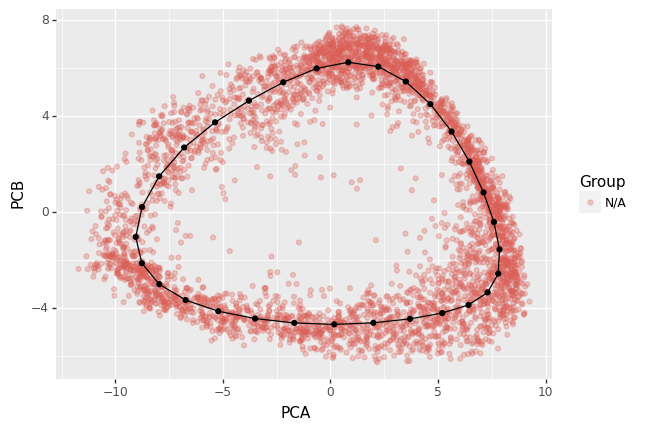

[<ggplot: (8788305057781)>]
node_min 14
deleted [ 2 14]
2 trajectories found
Vertices: [[14, 12, 4, 0, 28, 9, 20, 23, 17, 26, 7, 5, 29, 11, 22, 15, 6, 18, 13, 25, 8, 1, 3, 27, 10, 24, 21, 19, 16, 2]]
Edges: [[5, 4, 1, 25, 26, 11, 16, 15, 22, 21, 2, 27, 28, 13, 14, 6, 8, 9, 20, 19, 3, 0, 23, 24, 17, 18, 12, 10, 7]]
Edges: [(12, 14), (4, 12), (0, 4), (0, 28), (9, 28), (9, 20), (20, 23), (17, 23), (17, 26), (7, 26), (5, 7), (5, 29), (11, 29), (11, 22), (15, 22), (6, 15), (6, 18), (13, 18), (13, 25), (8, 25), (1, 8), (1, 3), (3, 27), (10, 27), (10, 24), (21, 24), (19, 21), (16, 19), (2, 16)]
Vertices: [[14]]
Edges: [[]]
Edges: []


In [9]:
# Compute principal circle (closed elastic principal curve)

import random
random.seed(1)

adata_cc.obs['proliferating'] = np.empty(len(adata_cc)).astype(np.int)
adata_cc.obs['proliferating'][:] = 1

egr, partition, X, Xp = _compute_principal_circle(adata_cc,number_of_nodes=30,Mu=0.5,n_components=30)

egr_closed = egr.copy()

egr, starting_node = open_principal_circle(egr[0],X)
adata.obs['total_counts_raw'] = adata.obs['total_counts']
traj, PseudoTimeTraj = _compute_pseudotime(adata_cc, egr, starting_node, Xp)
pst = PseudoTimeTraj[0]['Pseudotime']
points = PseudoTimeTraj[0]['Points']
node_median_counts,_ = _get_node_median_counts_from_feature(adata,'total_counts_raw',partition)

(30, 567)


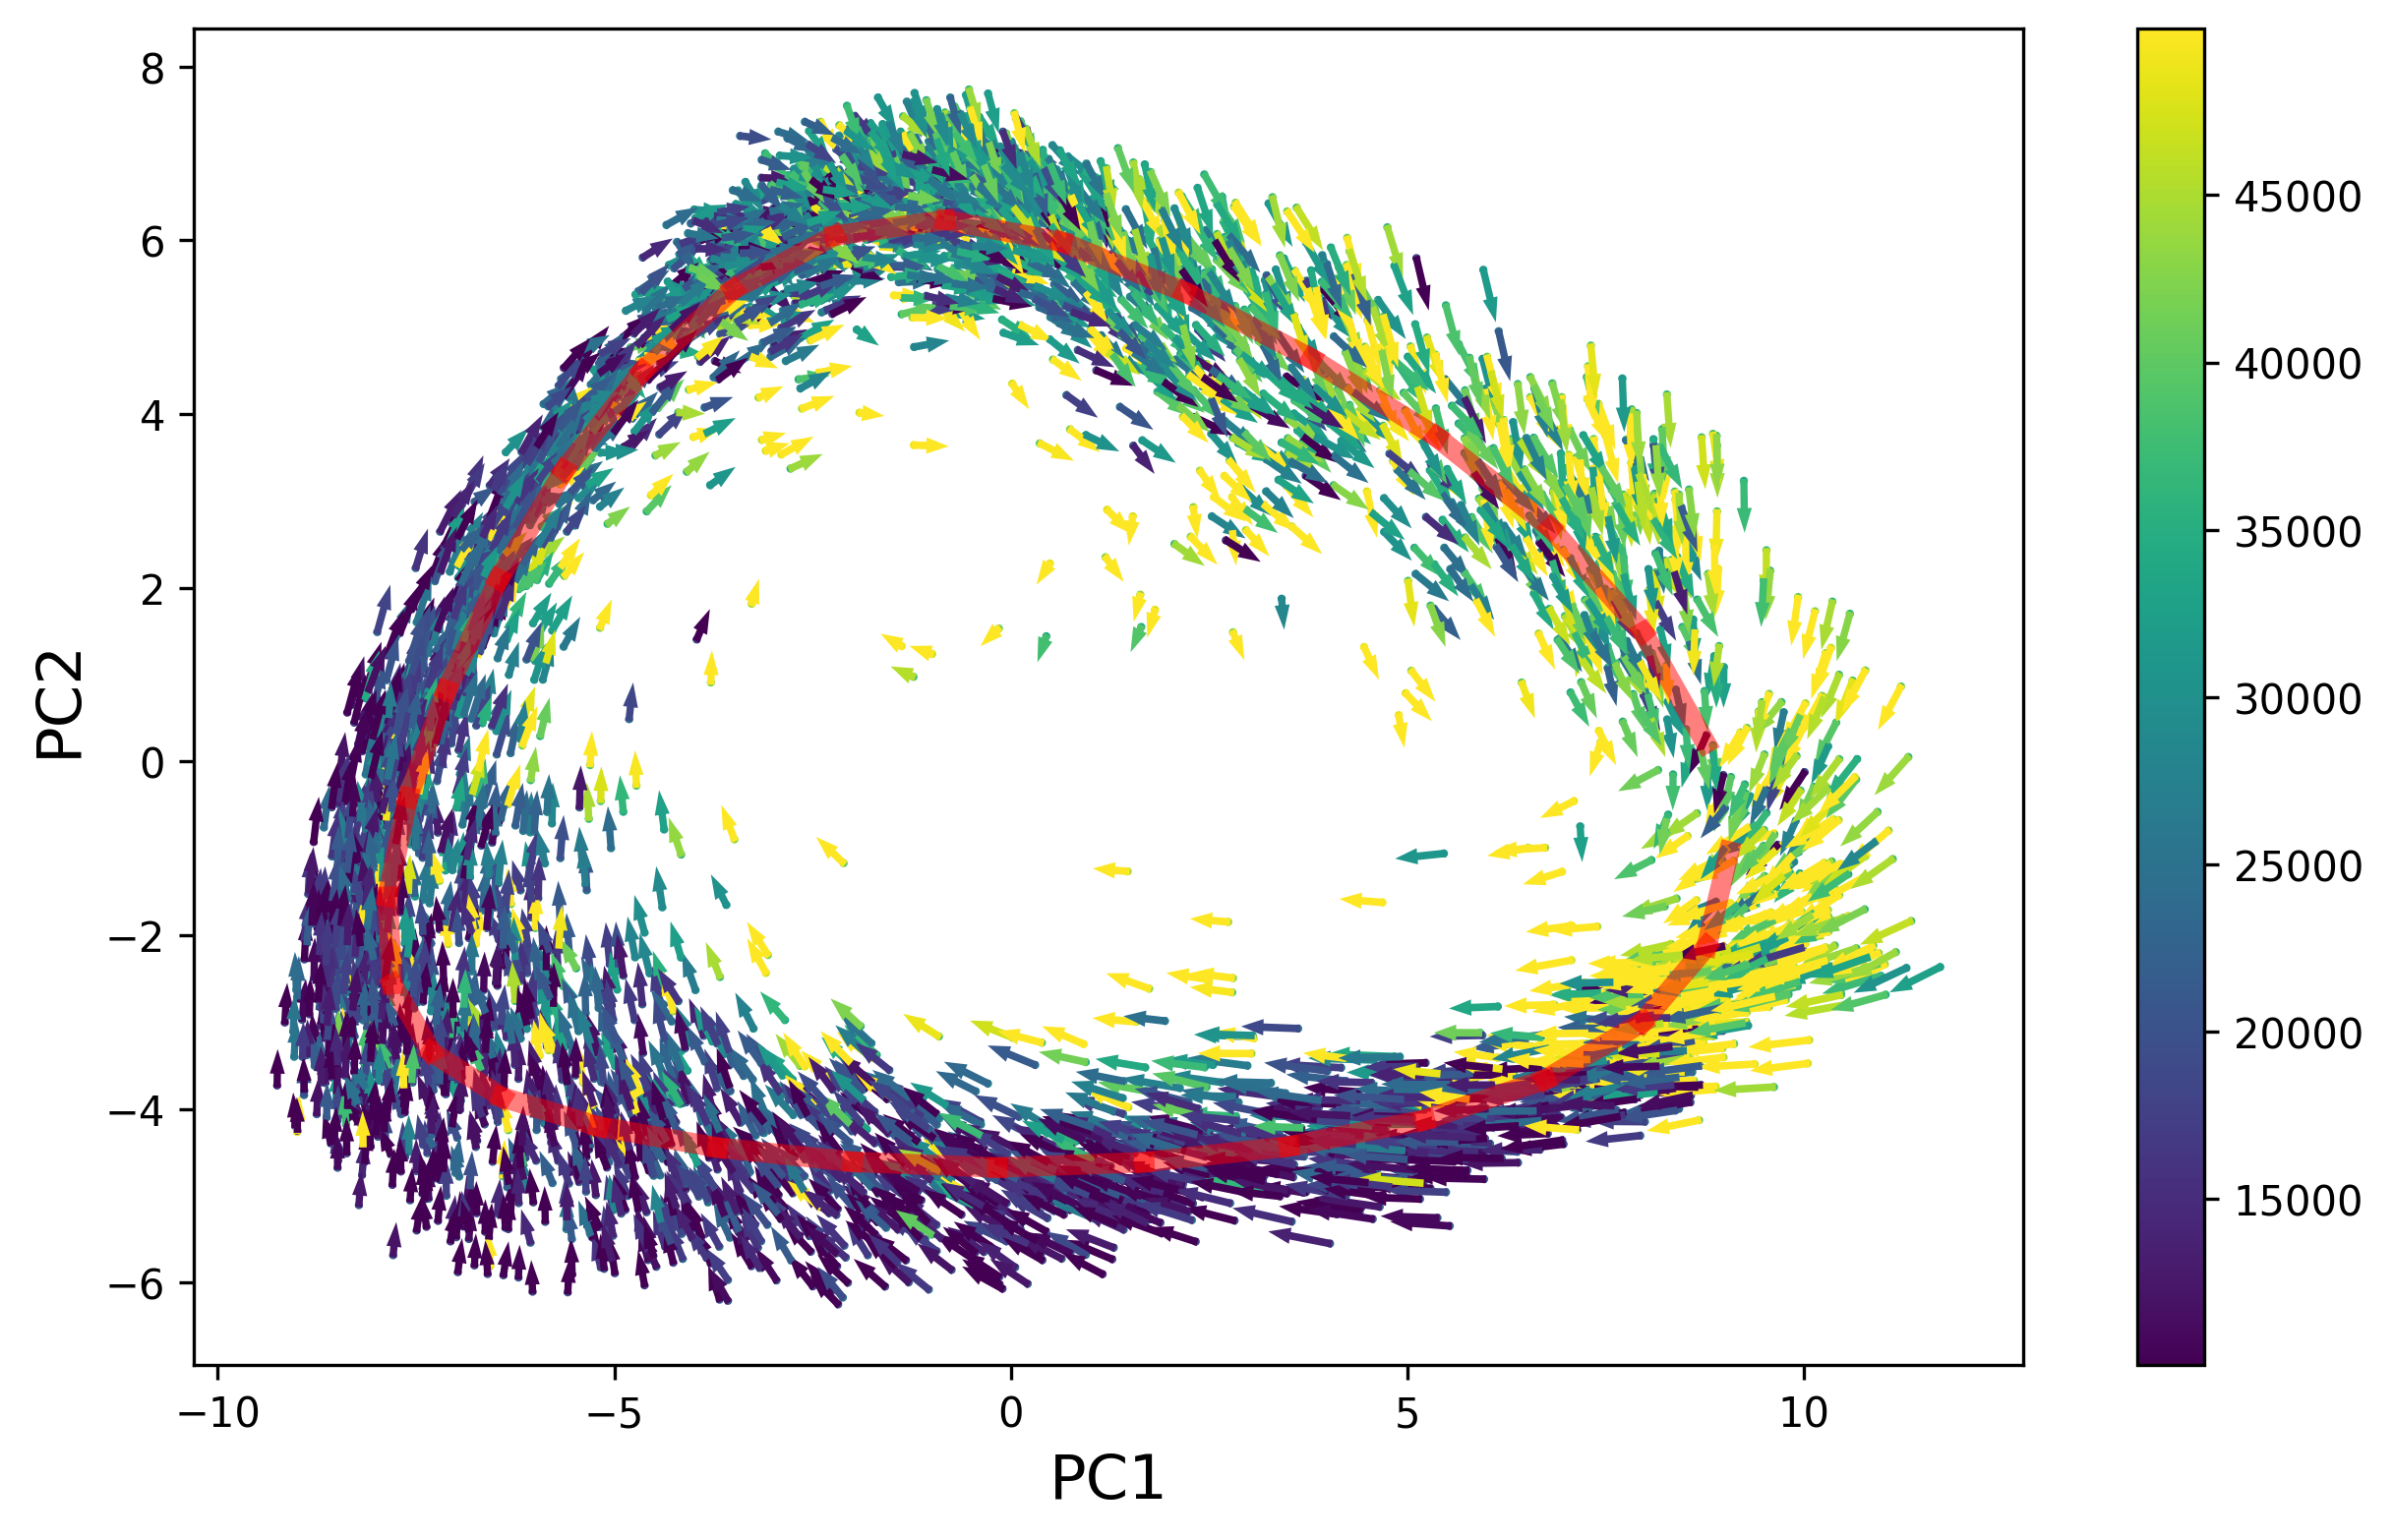

In [10]:
plt.rcParams['figure.dpi'] = 300
u1,u_nodes = _make_PCA_plot(adata_cc, [egr],figsize=(10,6),arrow_width=0.04)

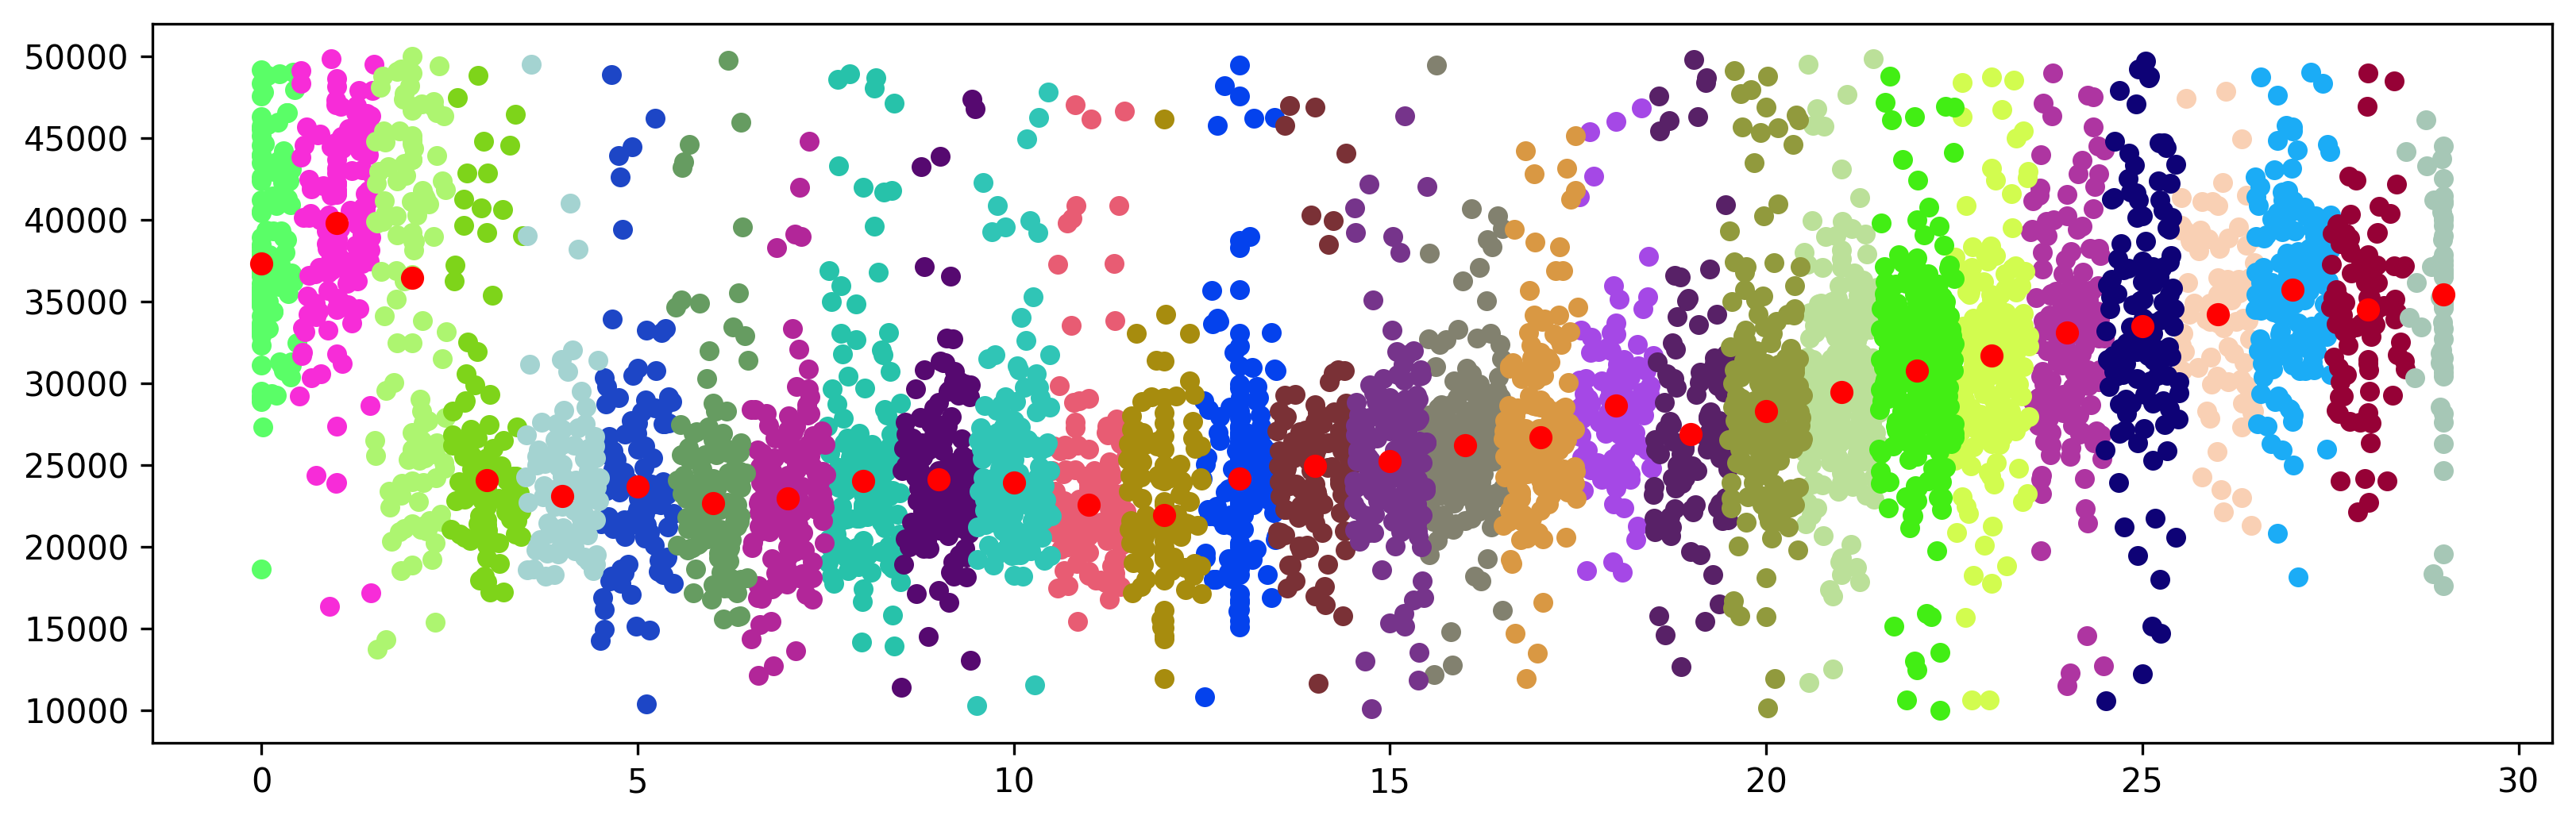

In [11]:
ad = adata_orig[adata.uns['ind_samples'],:].copy()
colors = _plot_count_plot_by_partition(ad,partition,PseudoTimeTraj,field='total_counts')

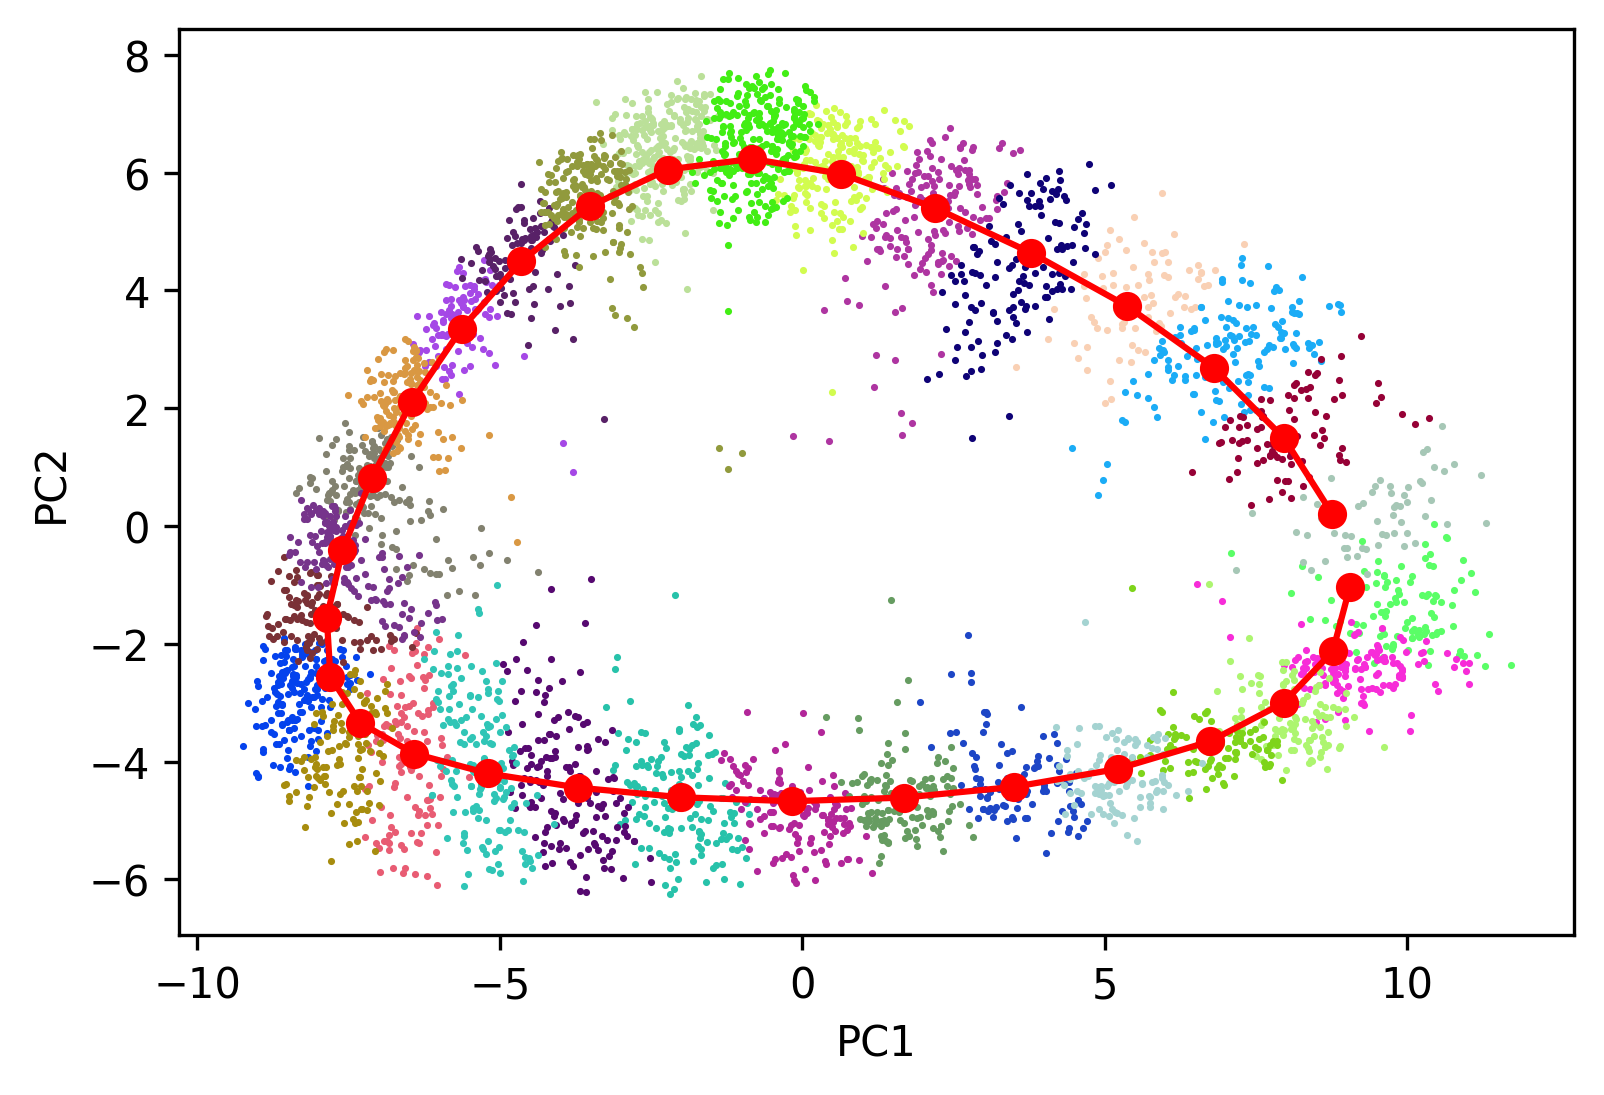

In [12]:
for i in range(len(u_nodes)):
    irx = np.where(partition==i)[0]
    plt.scatter(u1[irx,0],u1[irx,1],c=[colors[i]],s=0.5)
edges = egr['Edges'][0]
plt.plot(u_nodes[:,0],u_nodes[:,1],'ro')
for e in edges:
    plt.plot([u_nodes[e[0],0],u_nodes[e[1],0]],[u_nodes[e[0],1],u_nodes[e[1],1]],'r-')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


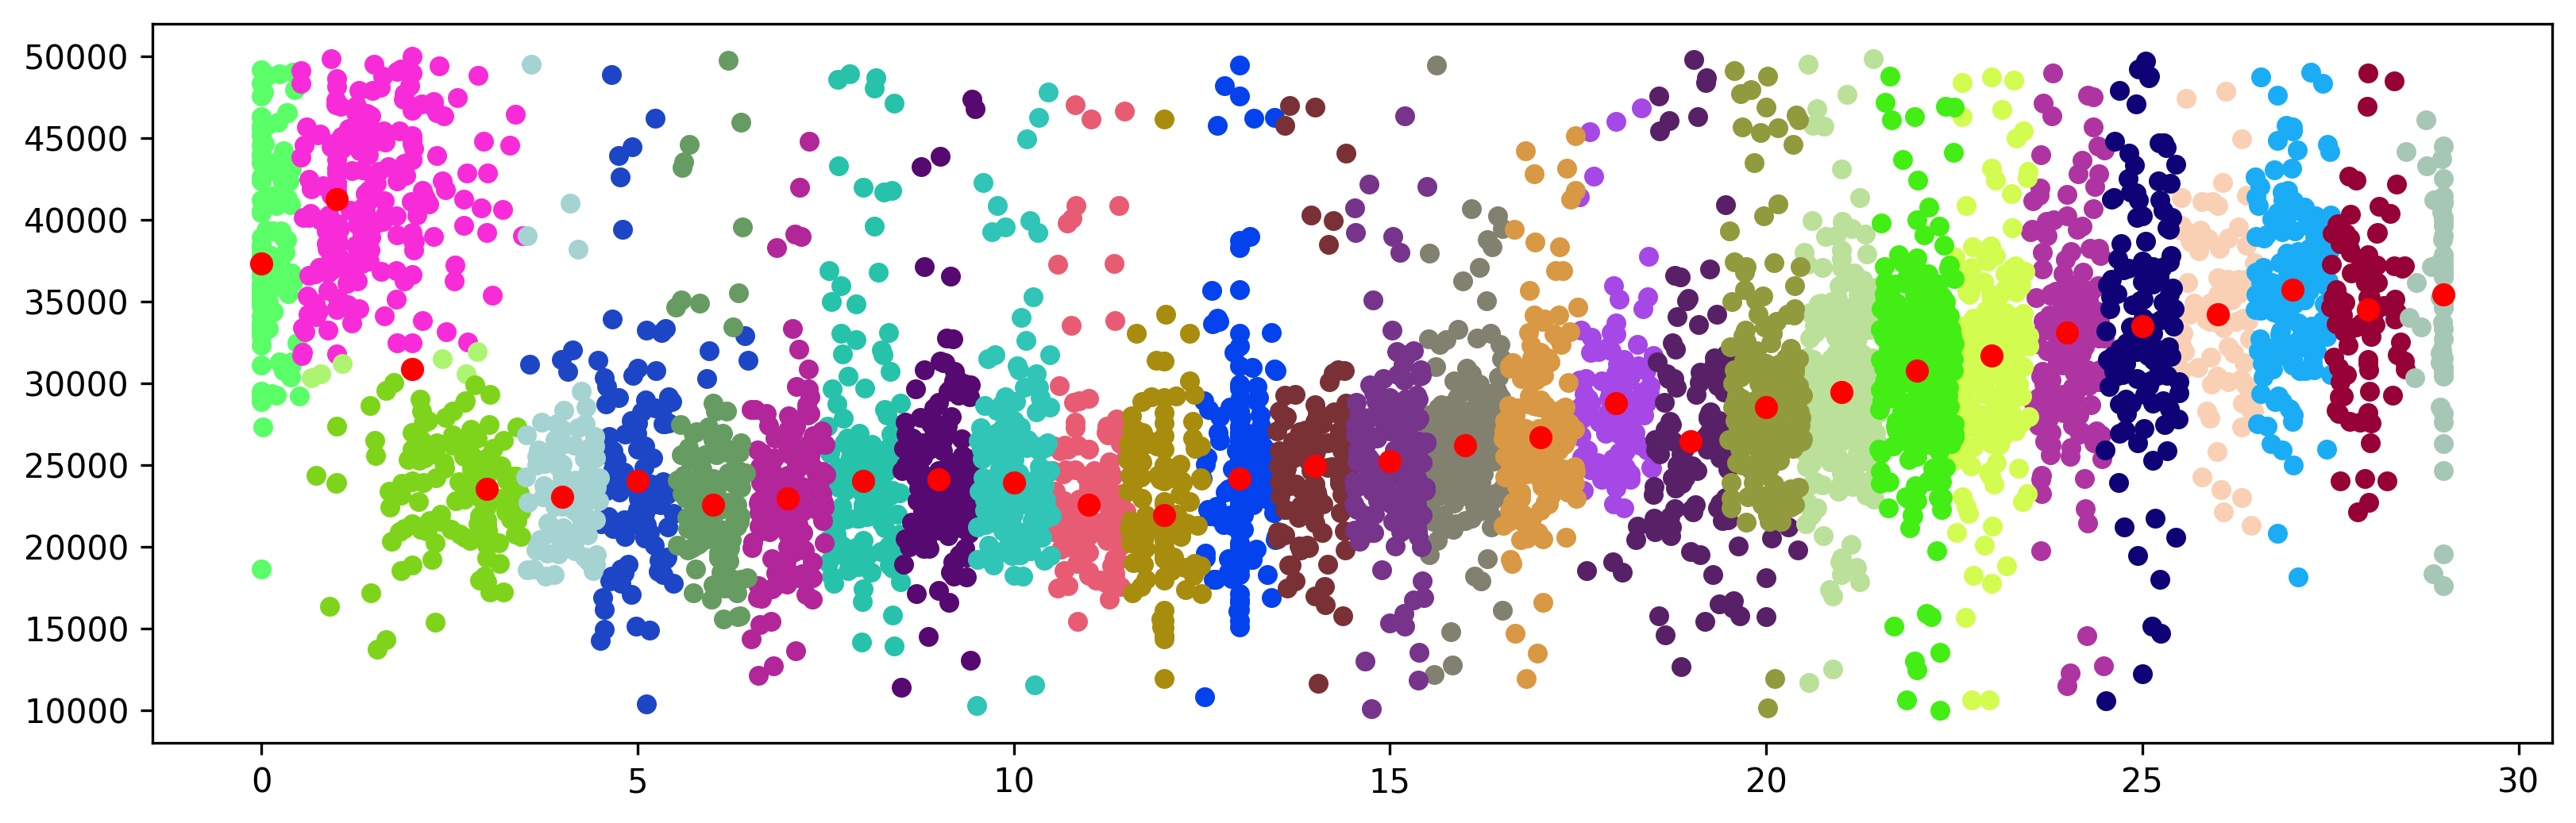

3
[15.0]
maximum iteration reached


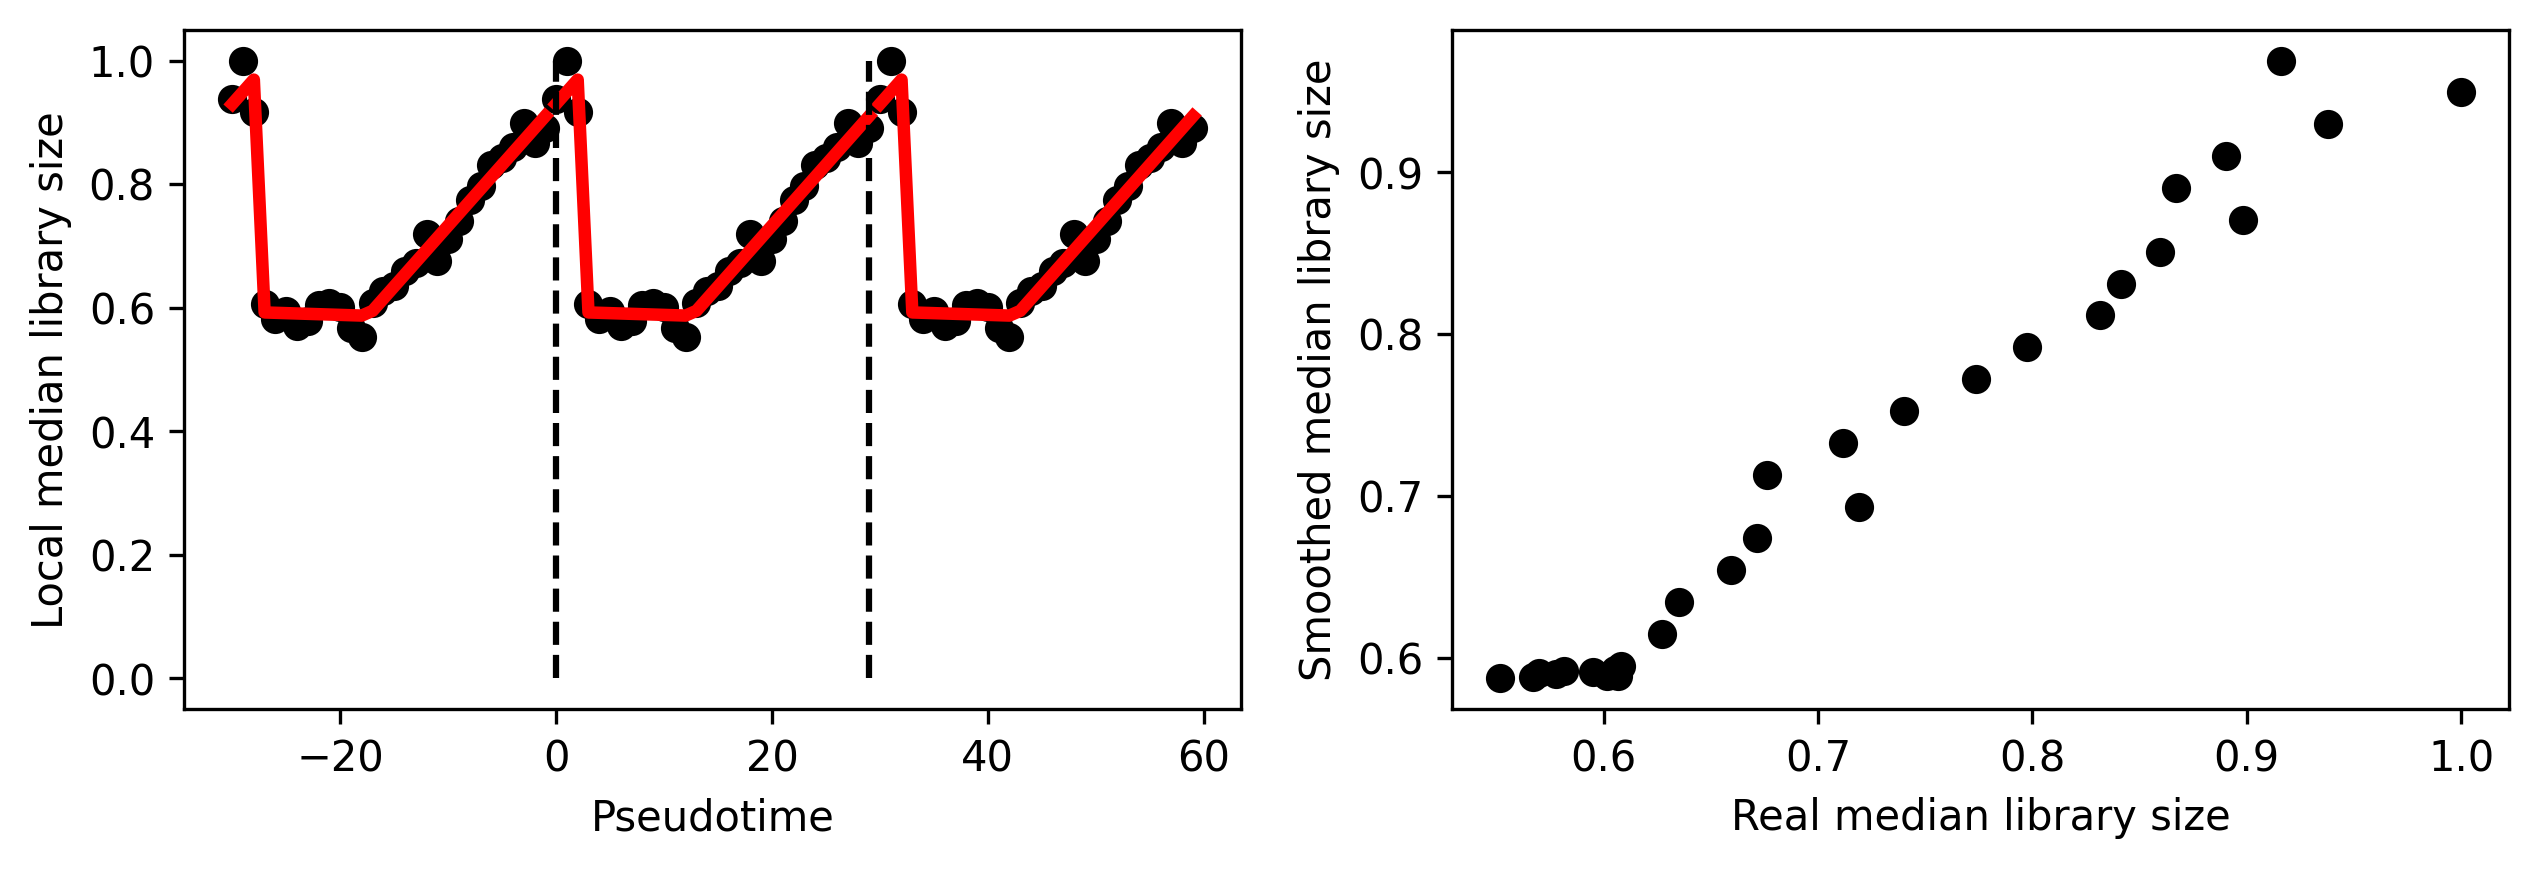

3
[15.0]


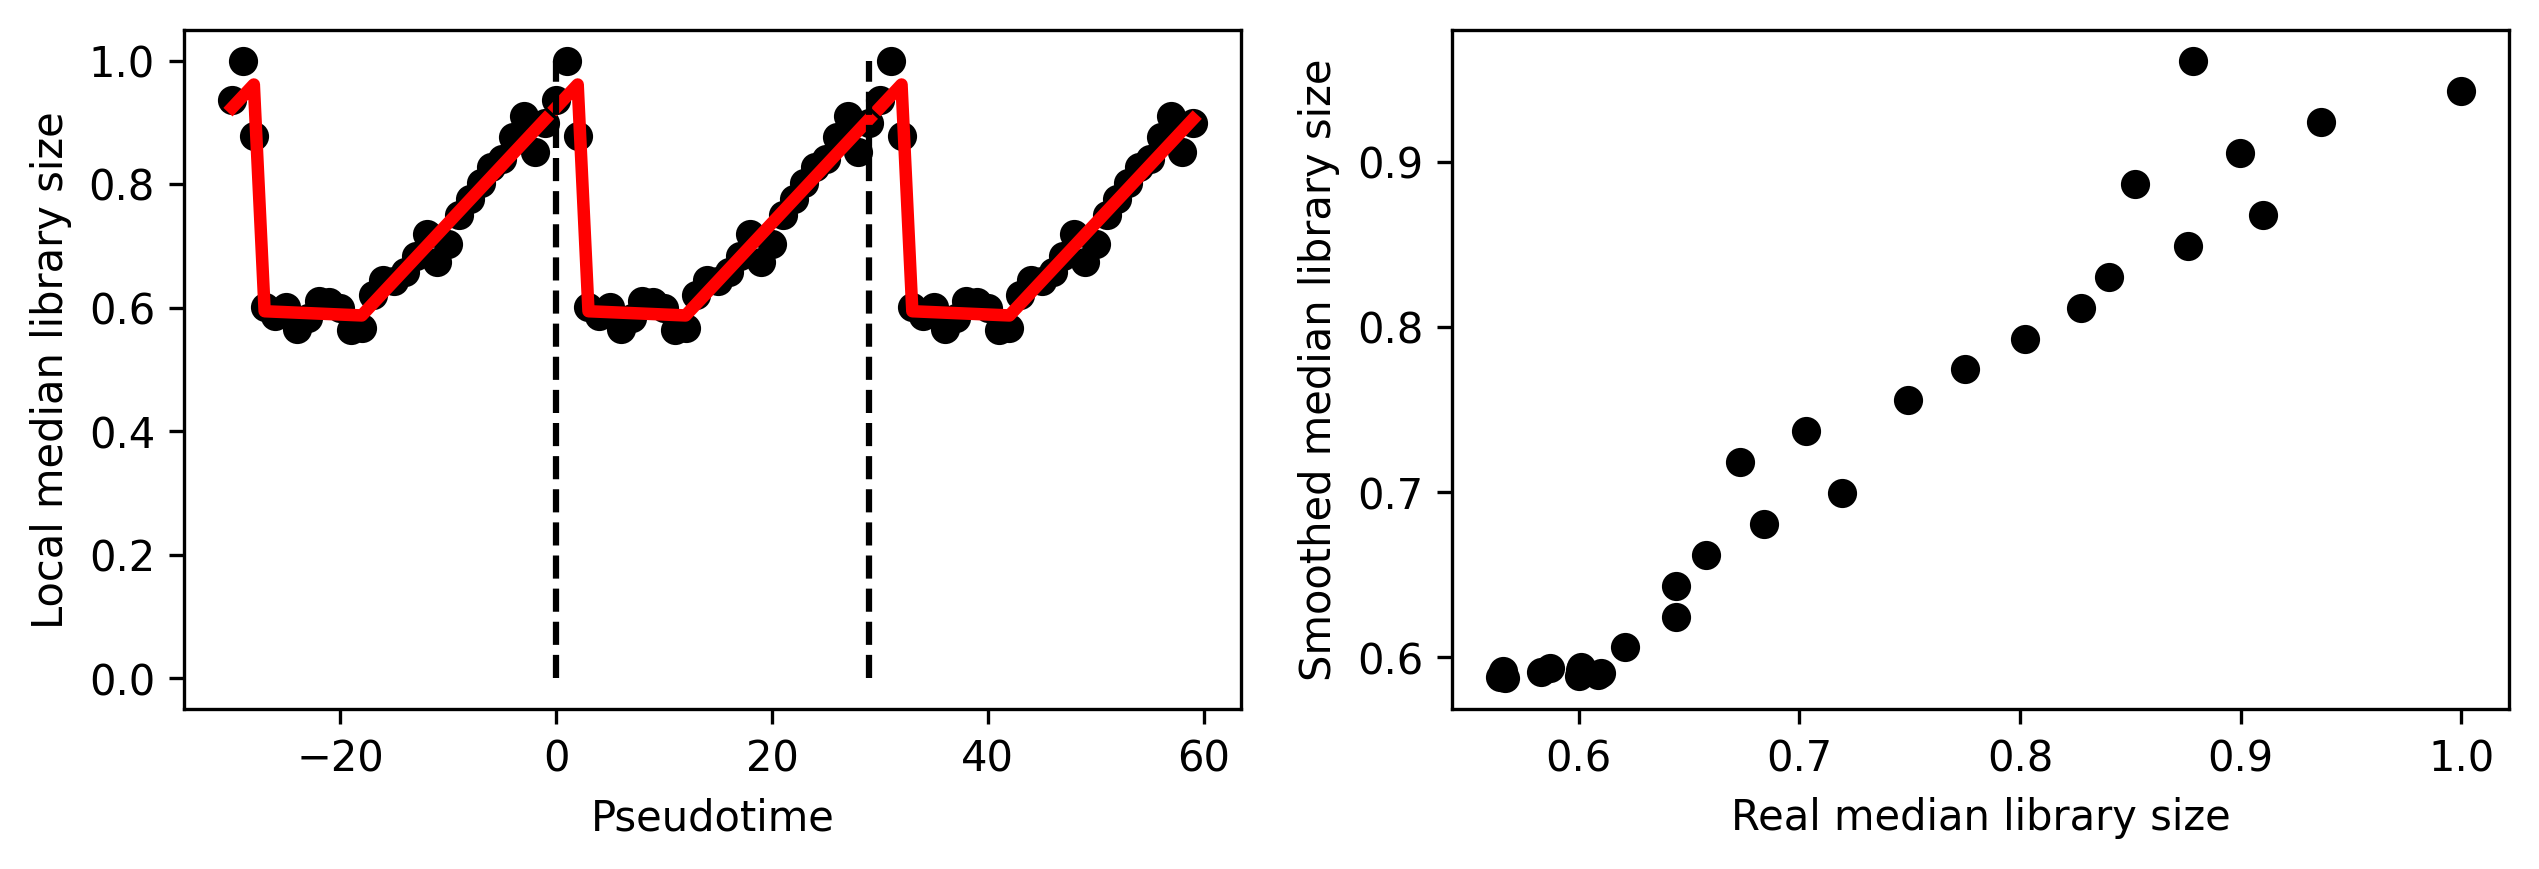

3
[15.0]
maximum iteration reached


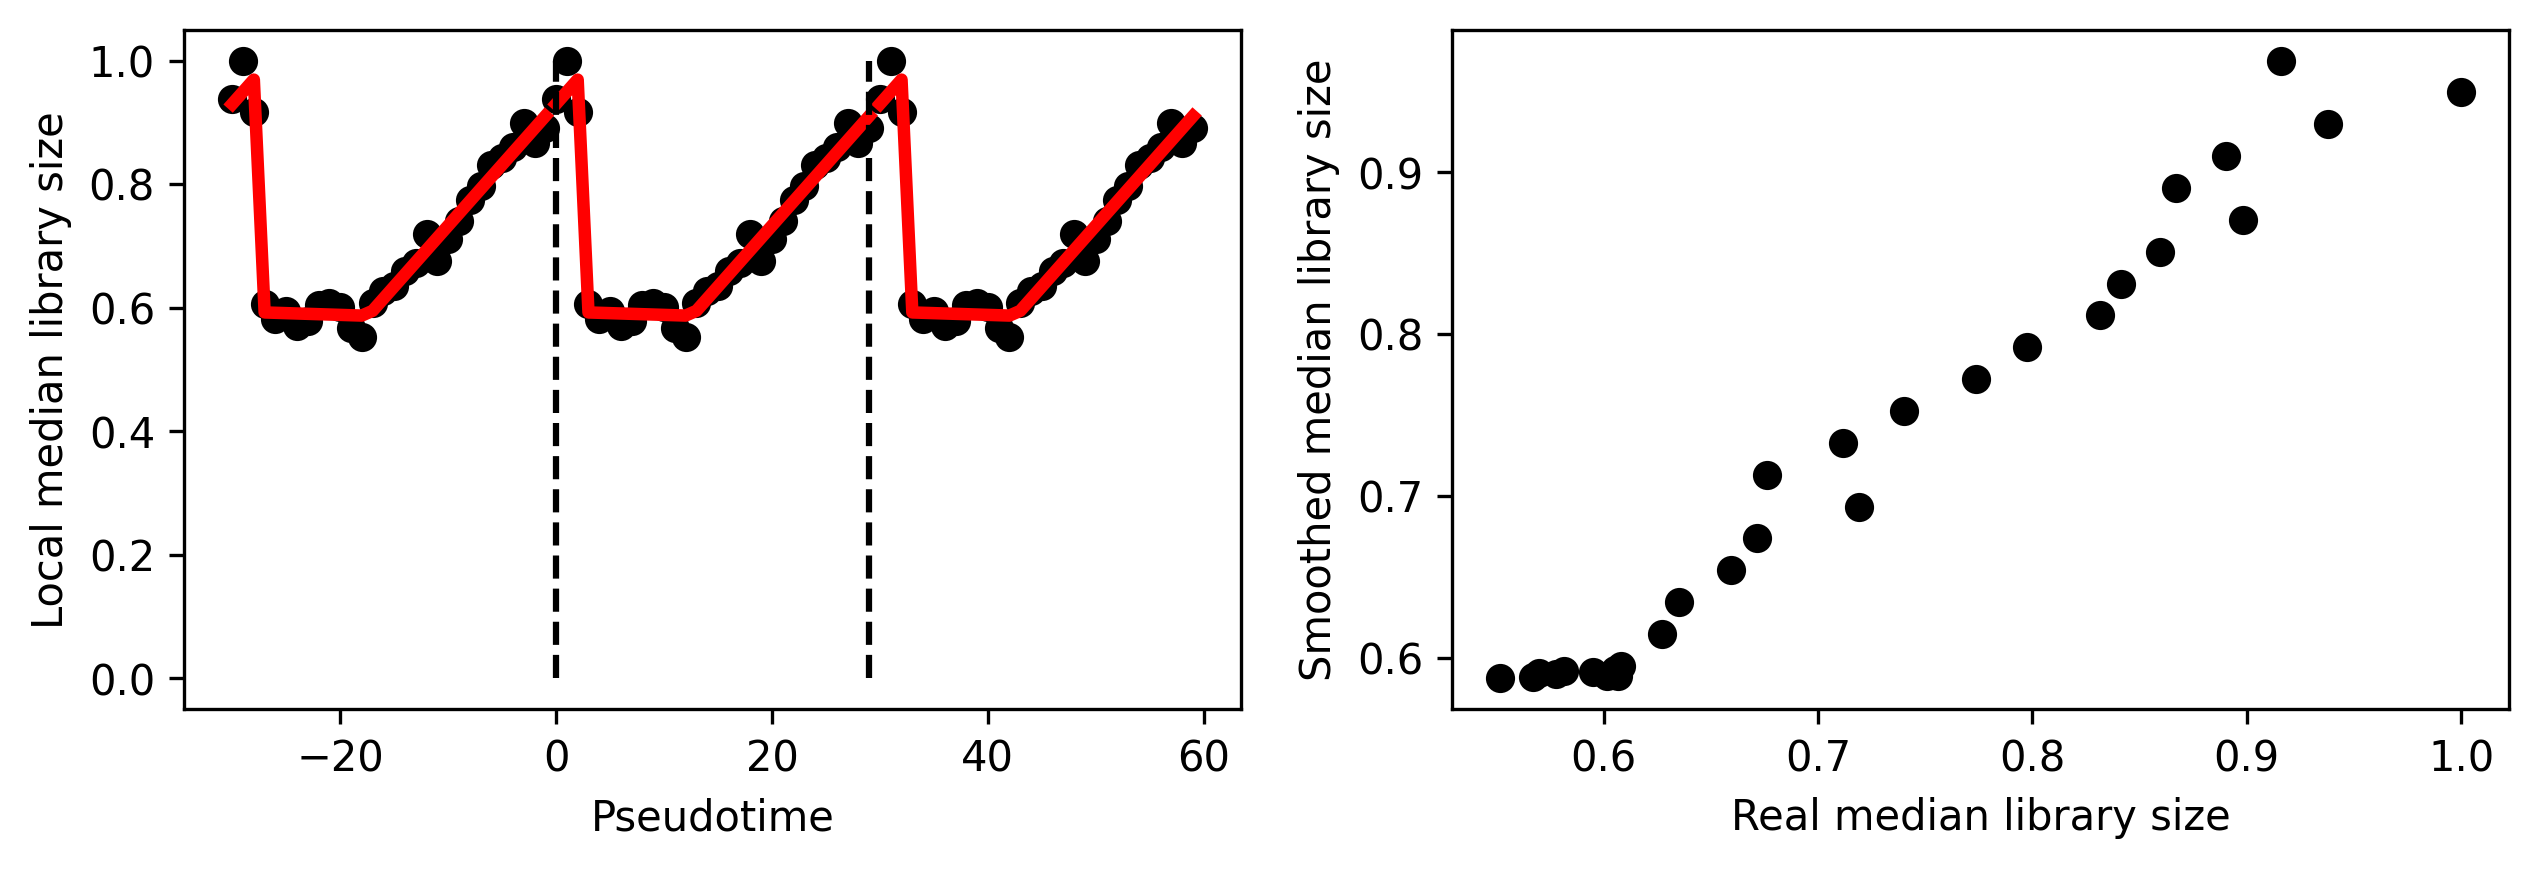

3
[15.0]


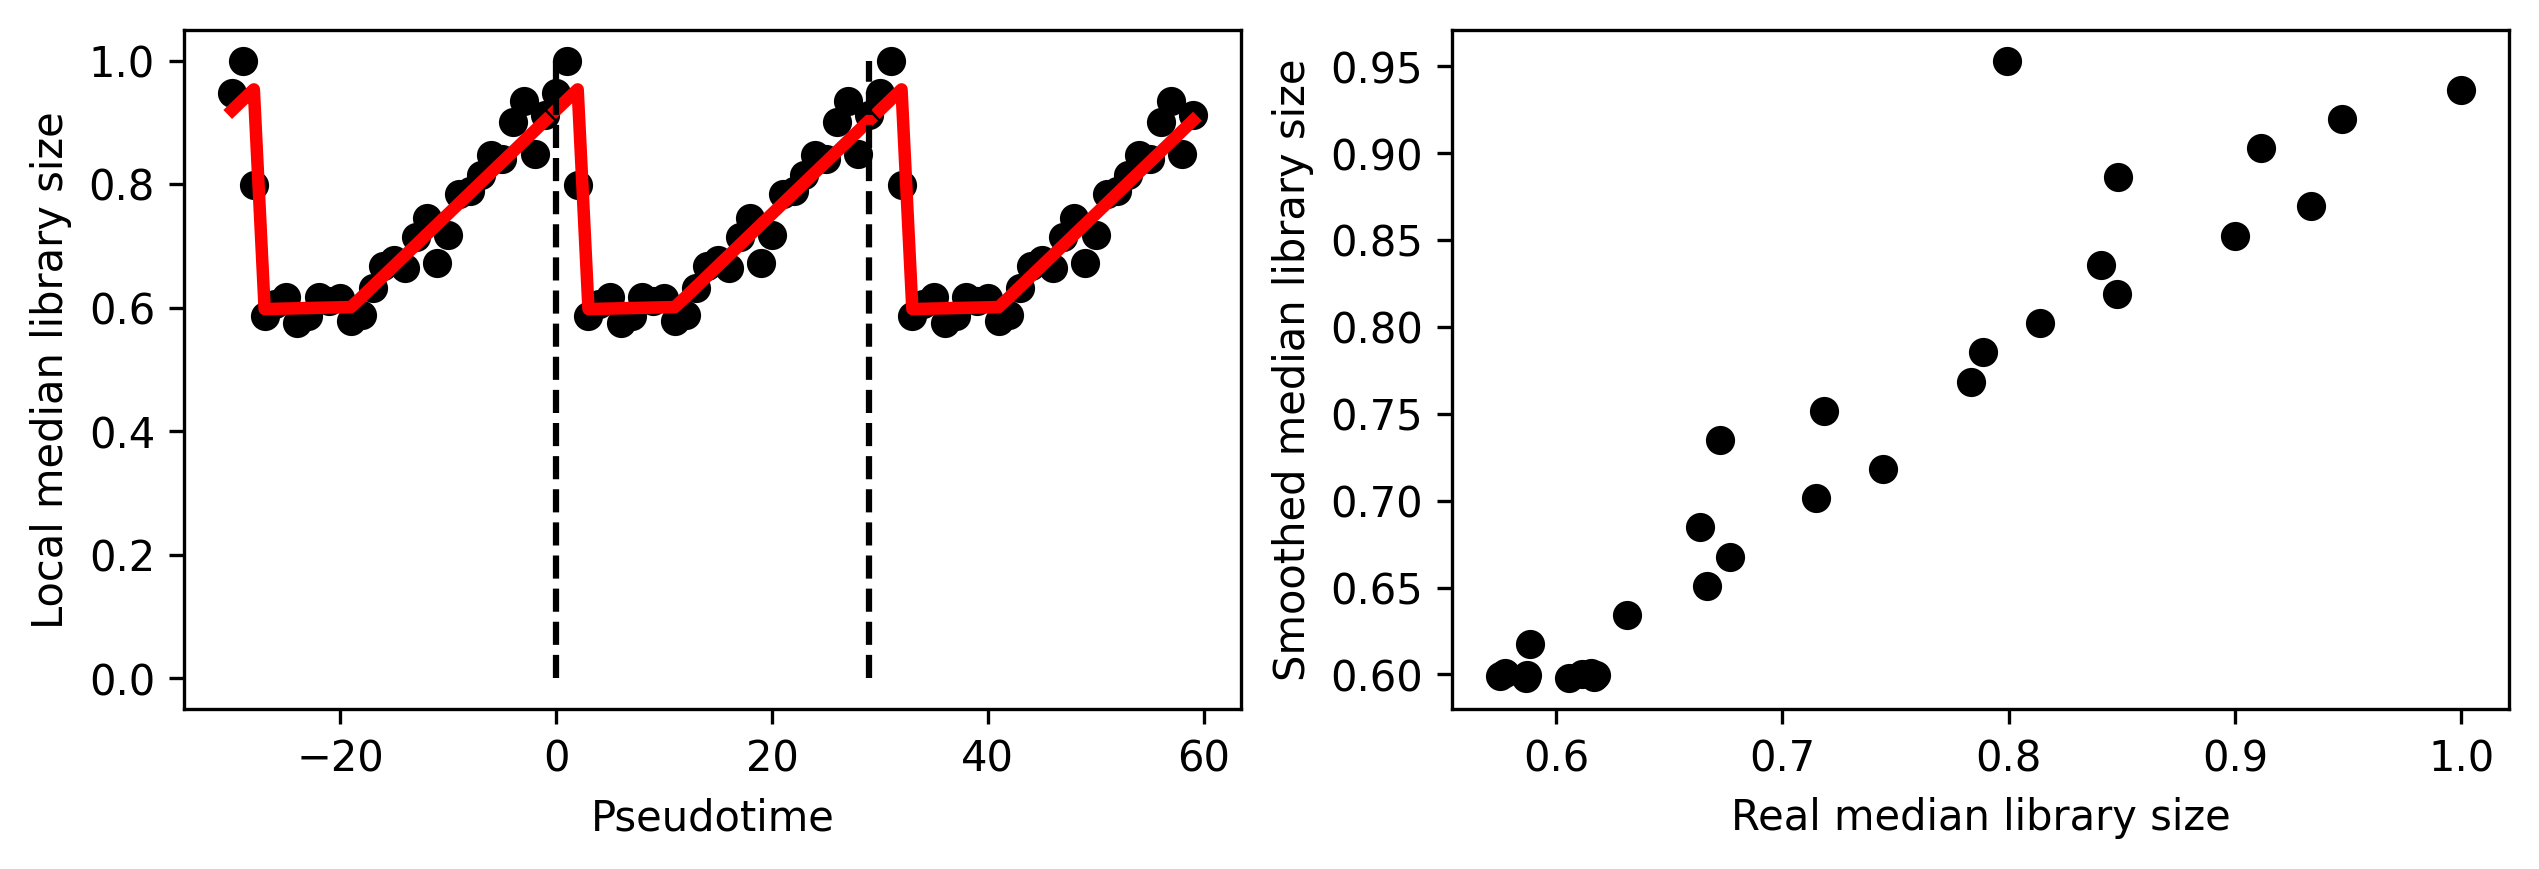

In [13]:
# renormalization to local median counts
adata_renorm_orig,adata_renorm = _renormalize(adata.copy(),adata_orig,egr,partition,pooling=True,smoothed=True,
                     PseudoTimeTraj=PseudoTimeTraj,smoothing_factor=0.15,reassignment_thresh=3.0,
                    max_number_of_iterations=10,colors=colors,piecewise_linear=2)

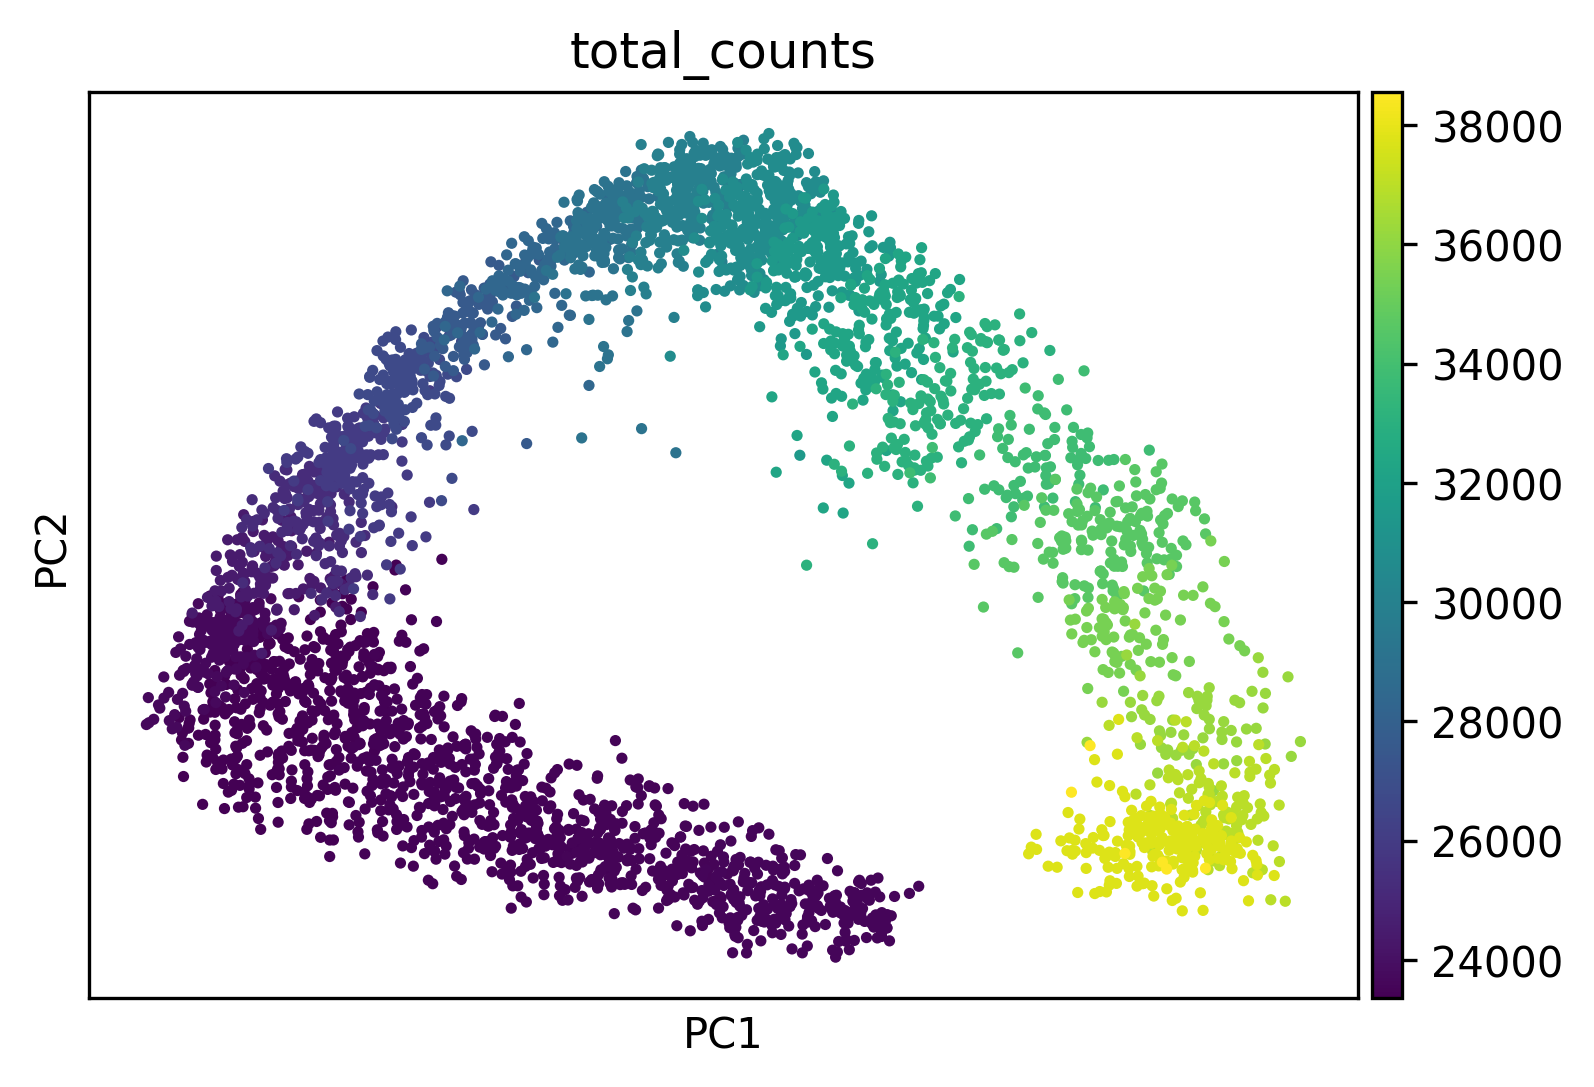

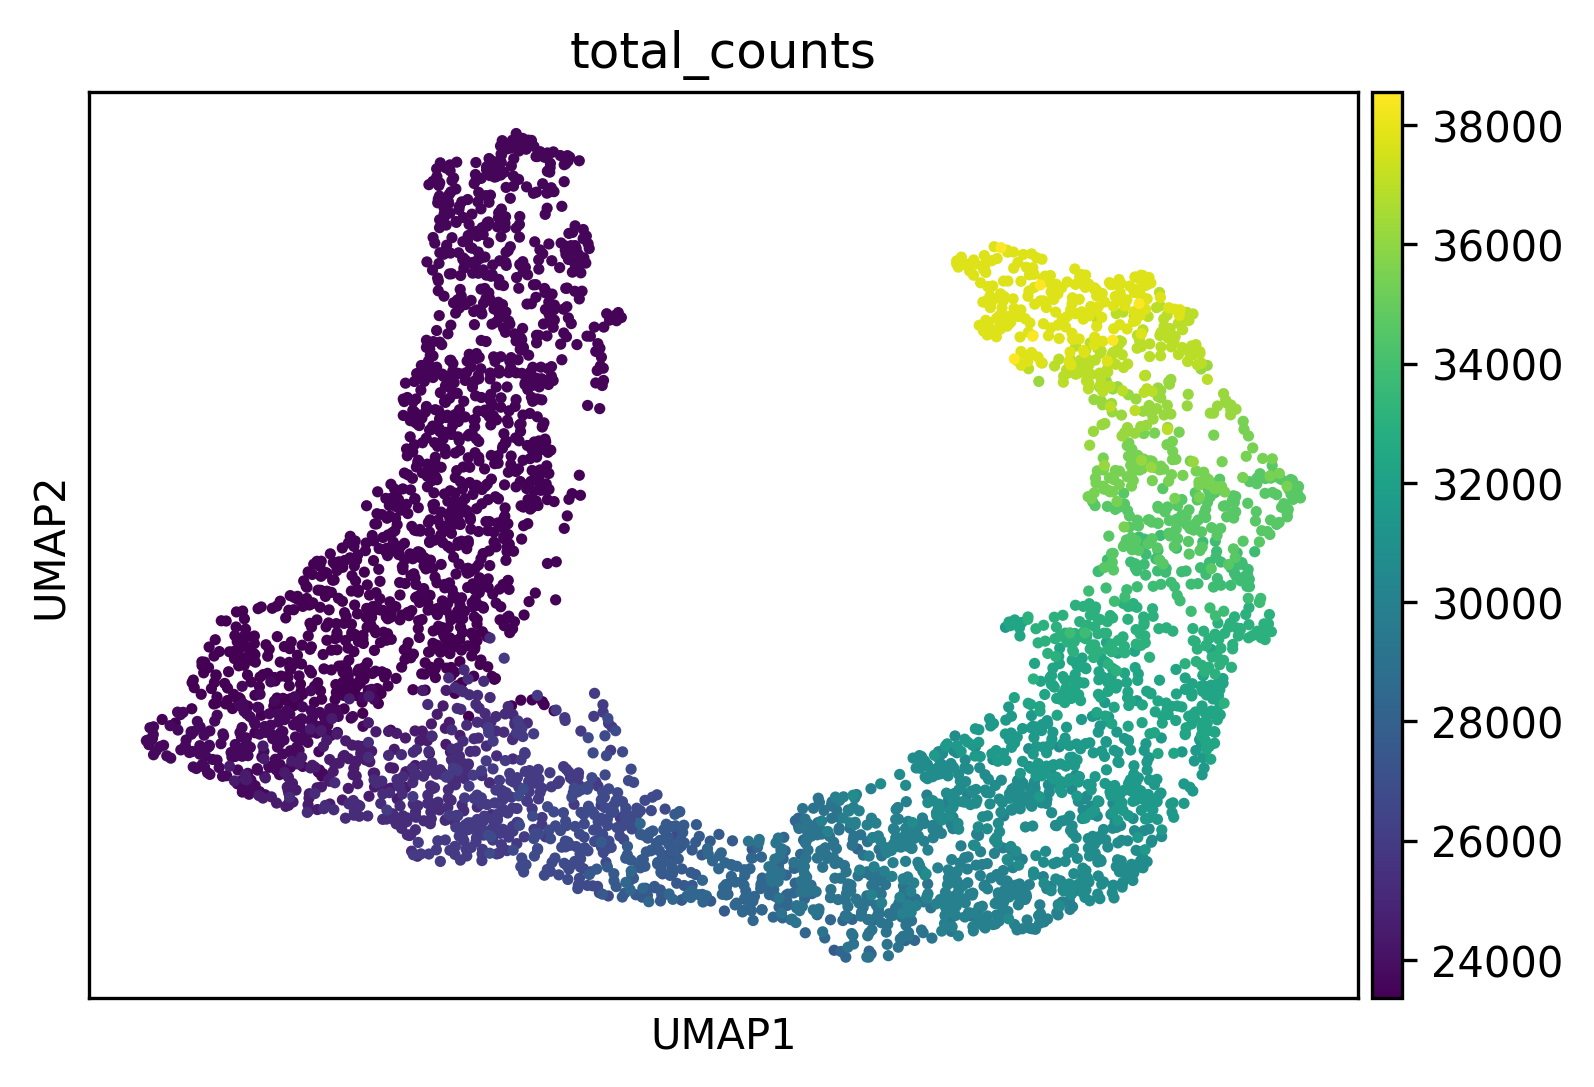

In [14]:
# Check the result of re-normalization in PCA and UMAP

adata_cc = adata_renorm[:,cc_genes]
sc.tl.pca(adata_cc,n_comps=30)
sc.pl.pca(adata_cc,color='total_counts')
sc.pp.neighbors(adata_cc, n_pcs = 30, n_neighbors = 10)
sc.tl.umap(adata_cc)
sc.pl.umap(adata_cc,color='total_counts')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:18) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:42) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


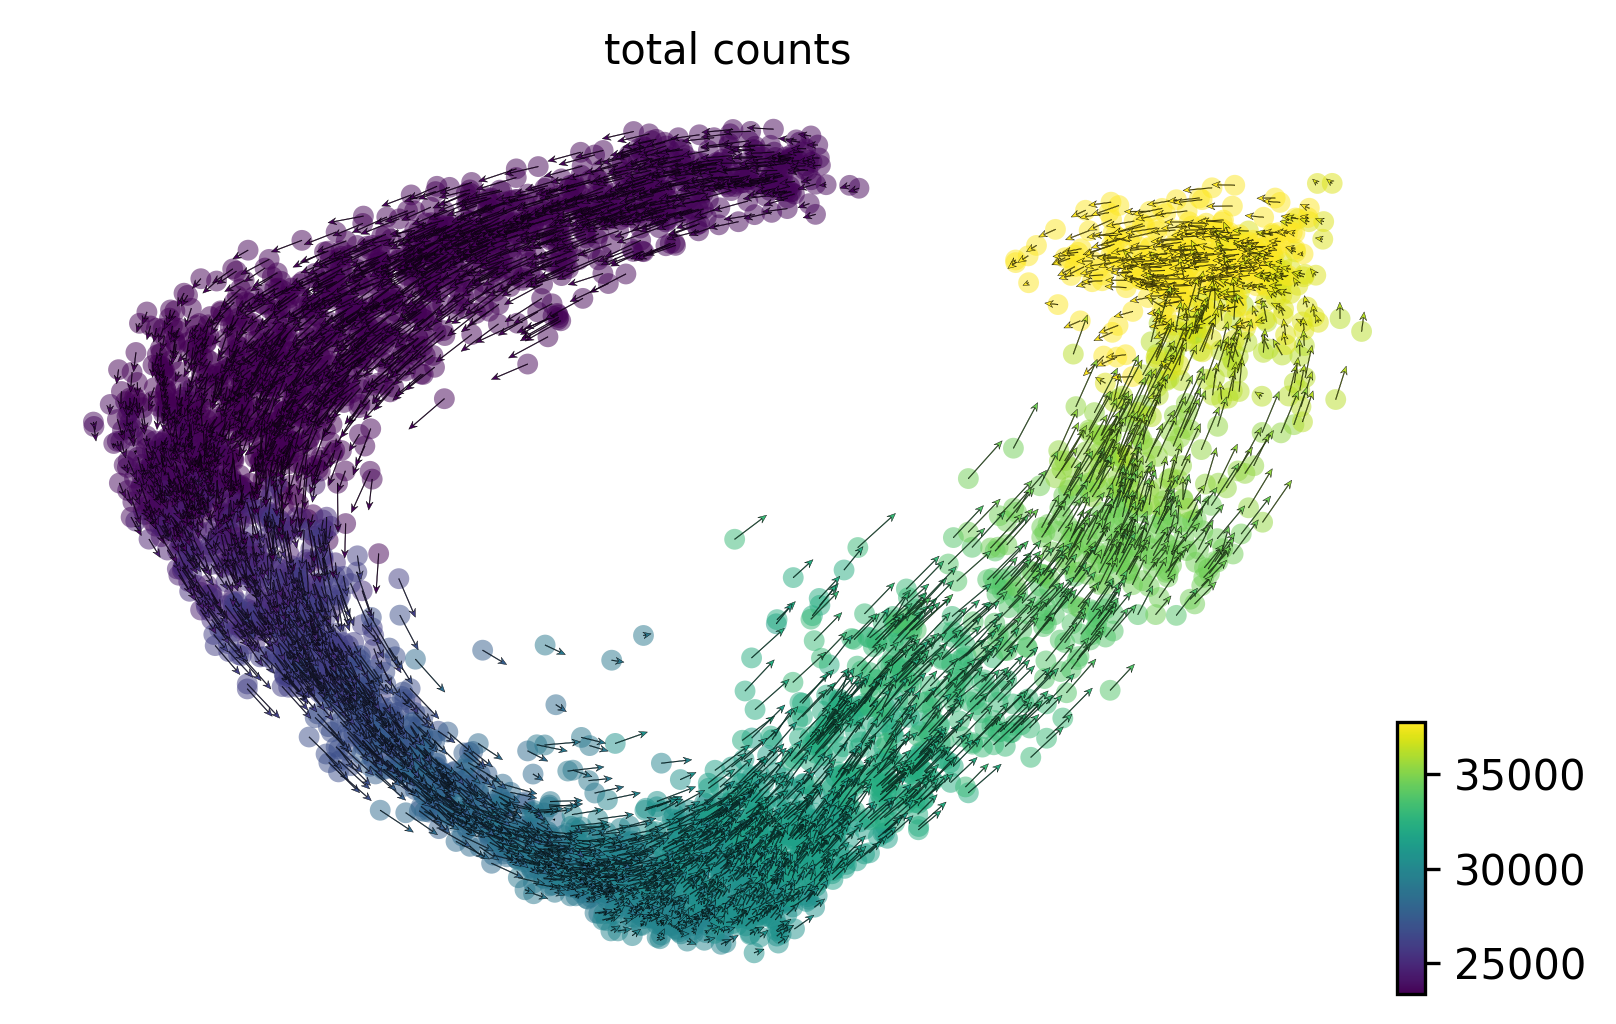

In [18]:
# Check the result of re-normalization in PCA with RNA Velocity
sv.pl.velocity_embedding(adata_renorm, basis='pca',components='1,2', color='total_counts', size=100, alpha=0.5,perc=[2,98],
                         arrow_size=1,dpi=300,arrow_length=10) 

In [19]:
# Save the result of renormalization for further use (e.g., in Part II of this notebook)

adata = adata_renorm
adata.write_h5ad(folder+dataset_name+'_proc_renorm.h5ad',compression='gzip')

# Part II. Computing the cell cycle trajectory and its curvature analysis

In [5]:
# Start from renormalized data
adata = sc.read_h5ad(folder+dataset_name+'_proc_renorm.h5ad')

In [7]:
# Compute ICA and select cell cycle-related components, 
# also define a dataset-specific list of cell cycle genes
_compute_ica(adata,thr=2.0)
print('Number of cell cycle-associated genes',len(adata.uns['cc_genes']))

-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1-S: 1 (score=9.380425)
G2-M: 6 (score=9.677717)
G2-M-: 14 (score=15.323152)
Histones: 3 (score=24.916149)
Number of cell cycle-associated genes 621


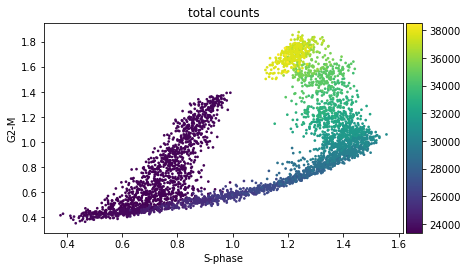

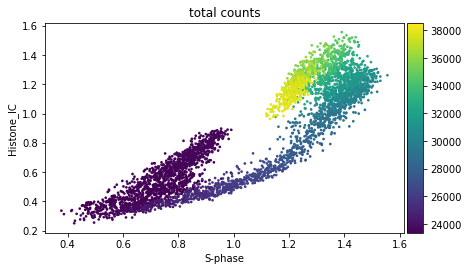

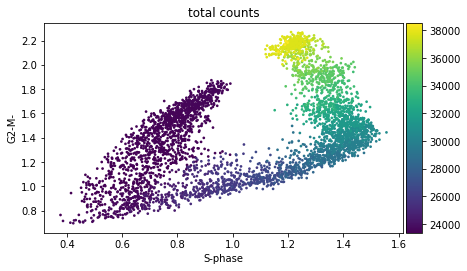

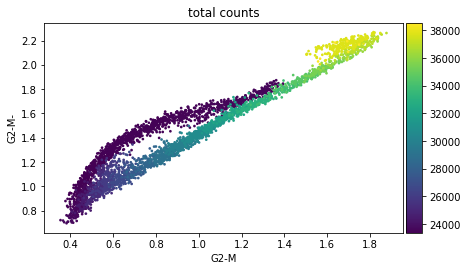

In [8]:
# Show projections on various independent components associated with cell cycle by scycle

sc.pl.scatter(adata,x='S-phase',y='G2-M',color='total_counts')
sc.pl.scatter(adata,x='S-phase',y='Histone_IC',color='total_counts')
sc.pl.scatter(adata,x='S-phase',y='G2-M-',color='total_counts')
sc.pl.scatter(adata,x='G2-M',y='G2-M-',color='total_counts')
#print(adata.uns['cc_genes'])

In [9]:
# Compute RNA Velocity field

_compute_velocity(adata)

computing moments based on connectivities
    finished (0:00:21) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


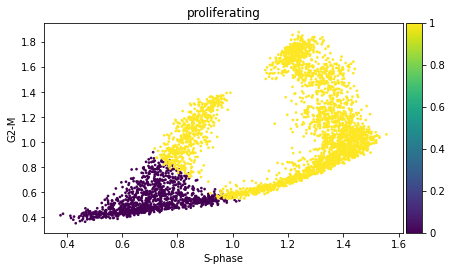

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  2896  points and  2  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	0.0063	30	30	30	0	0	0	0.003	0.0024	0.9813	0.9848	0.0023	0.0011	0.0328	0.9825	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
1.7334  seconds elapsed


Iteration 0 Fraction of non-proliferating cells: 0.25985013294657966 



The initial number of n

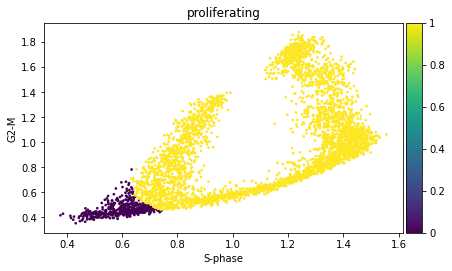

In [10]:
# Distinguish proliferating and non-proliferating cells (adjust number_of_sigmas - results might be very different)
adata_cc = adata[:,adata.uns['cc_genes']].copy()
find_nonproliferative_cells(adata_cc,number_of_sigmas=3,Mu=0.3)
sc.pl.scatter(adata_cc,x='S-phase',y='G2-M',color='proliferating')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3637  points and  30  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	8.8296	30	30	30	0	0	0	7.0108	6.7527	0.9026	0.9062	1.0659	0.7529	22.5882	677.6452	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
2.8949  seconds elapsed


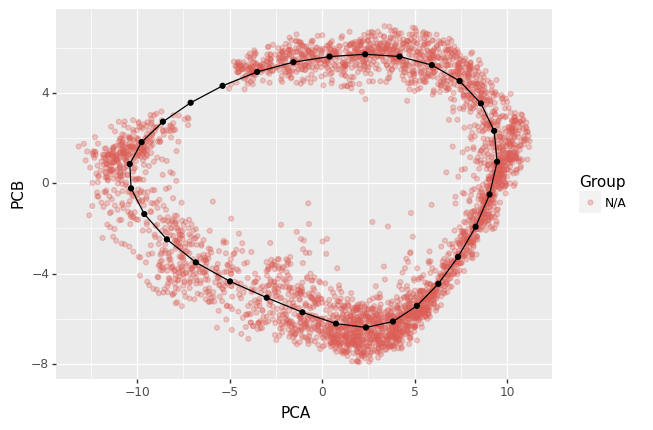

[<ggplot: (8773912062241)>]
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
Computing EPG with  60  nodes on  3637  points and  30  dimensions
Nodes =  29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||60	6.4711	60	59	58	0	0	0	6.1484	6.0716	0.9146	0.9157	0.0569	0.2658	15.9482	956.8906	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
10.1226  seconds elapsed


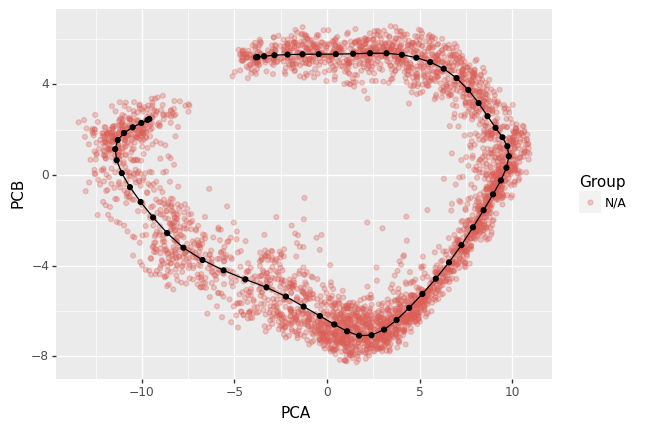

[<ggplot: (8773928498557)>]
2 trajectories found
Vertices: [[27, 13, 3, 0, 37, 52, 47, 42, 34, 29, 25, 22, 59, 19, 6, 35, 40, 50, 57, 45, 30, 12, 16, 8, 10, 24, 53, 36, 31, 46, 4, 28, 55, 41, 14, 18, 23, 5, 56, 20, 43, 33, 51, 1, 26, 7, 38, 44, 49, 32, 58, 15, 11, 39, 48, 54, 2, 17, 21, 9]]
Edges: [[17, 2, 0, 24, 43, 44, 36, 29, 21, 19, 14, 58, 57, 8, 22, 27, 40, 54, 53, 33, 20, 5, 4, 1, 13, 45, 46, 23, 35, 34, 18, 49, 50, 28, 7, 12, 11, 51, 52, 30, 31, 42, 41, 15, 16, 25, 32, 39, 38, 56, 55, 3, 26, 37, 48, 47, 6, 10, 9]]
Edges: [(13, 27), (3, 13), (0, 3), (0, 37), (37, 52), (47, 52), (42, 47), (34, 42), (29, 34), (25, 29), (22, 25), (22, 59), (19, 59), (6, 19), (6, 35), (35, 40), (40, 50), (50, 57), (45, 57), (30, 45), (12, 30), (12, 16), (8, 16), (8, 10), (10, 24), (24, 53), (36, 53), (31, 36), (31, 46), (4, 46), (4, 28), (28, 55), (41, 55), (14, 41), (14, 18), (18, 23), (5, 23), (5, 56), (20, 56), (20, 43), (33, 43), (33, 51), (1, 51), (1, 26), (7, 26), (7, 38), (38, 44), (44, 49), 

In [11]:
egr_final, partition_final,starting_node_final,X_final,Xp_final = _compute_principal_curve(adata_cc, Mu=0.3, Lambda=0.001,number_of_nodes=60,n_components=30)
traj_final, PseudoTimeTraj_final = _compute_pseudotime(adata, egr_final[0], starting_node_final, Xp_final)

(60, 621)


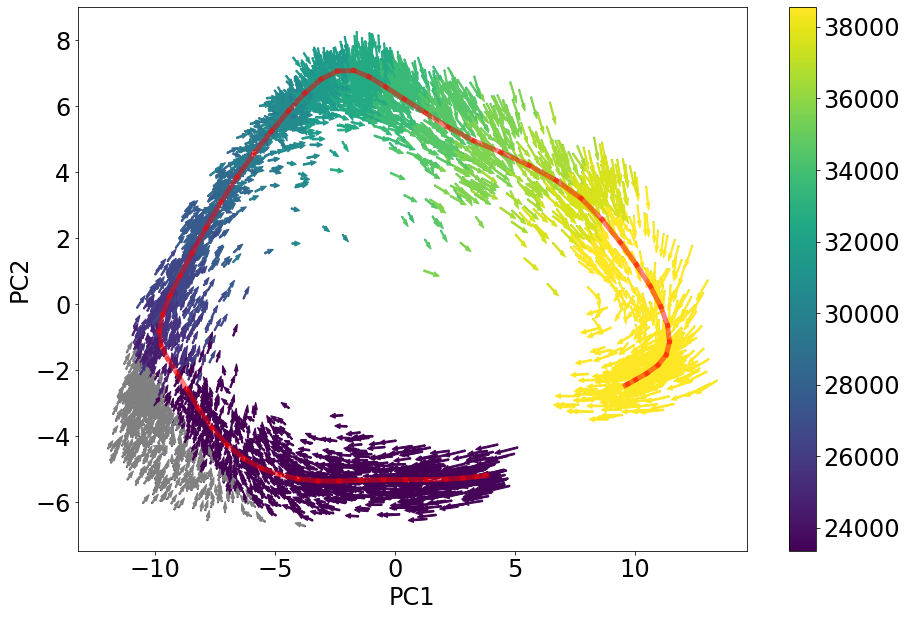

In [41]:
plt.rcParams.update({'font.size': 24})
subsample_size = 2000
idx_subsample = np.random.choice(range(len(adata)),subsample_size,replace=False)
idx_subsample = None

u1,u_nodes = _make_PCA_plot(adata_cc, egr_final,figsize=(15,10),arrow_width=0.05,tc_name='total_counts',delta=0.05,subsample=idx_subsample)

(4137, 2)
(4137, 2)
(4137, 2)


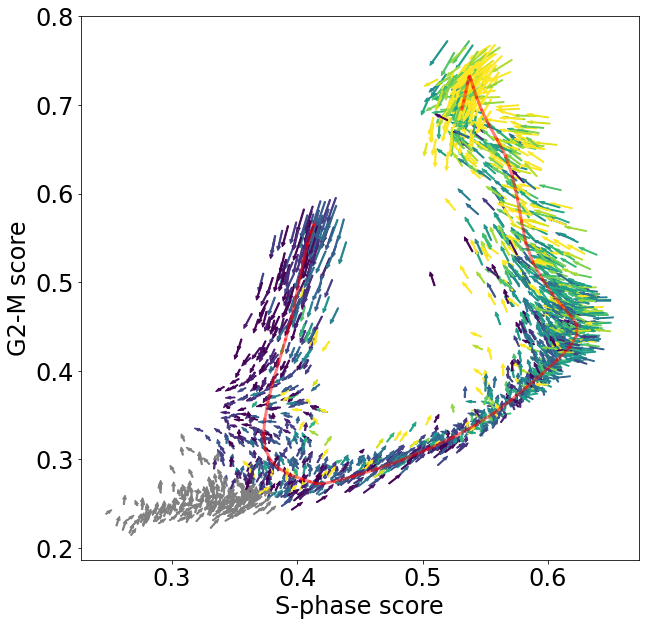

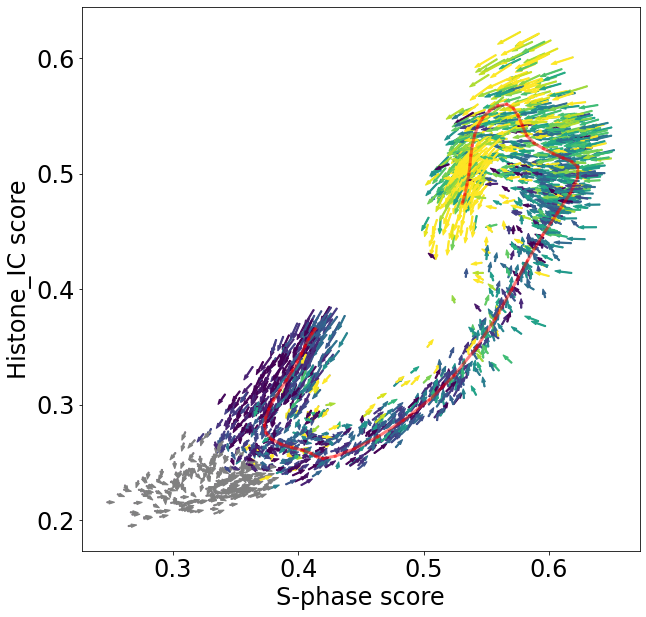

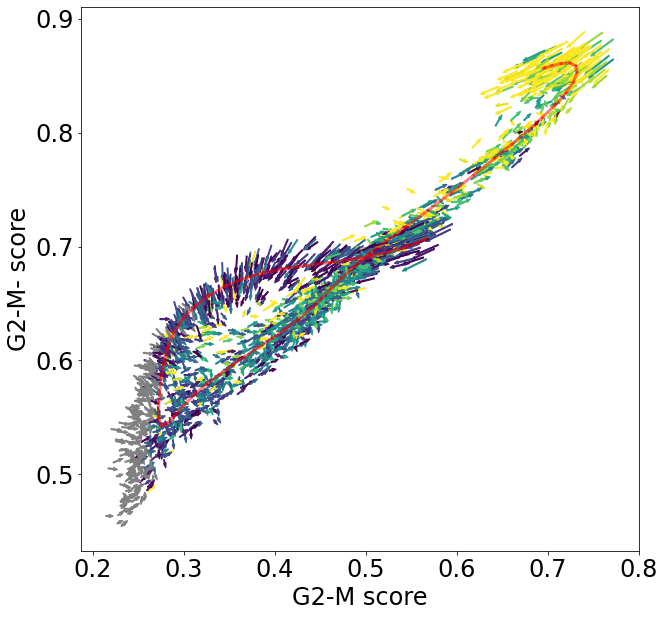

In [35]:
plt.rcParams.update({'font.size': 24})
subsample_size = 2000
idx_subsample = np.random.choice(range(len(adata)),subsample_size,replace=False)
delta = 0.05
arrow_width = 0.001

_make_G1SG2M_plot(adata_cc,egr_final,delta=delta,arrow_width=arrow_width,featurex=('S-phase_genes','S-phase'),featurey=('G2-M_genes','G2-M'),figsize=(10,10),subsample=idx_subsample)
_make_G1SG2M_plot(adata_cc,egr_final,delta=delta,arrow_width=arrow_width,featurex=('S-phase_genes','S-phase'),featurey=('Histone_IC_genes','Histone_IC'),figsize=(10,10),subsample=idx_subsample)
_make_G1SG2M_plot(adata_cc,egr_final,delta=delta,arrow_width=arrow_width,featurex=('G2-M_genes','G2-M'),featurey=('G2-M_INH_genes','G2-M-'),figsize=(10,10),subsample=idx_subsample)
#_make_G1SG2M_plot(adata, egr, n_components=30, delta=0.05, subsample=None,highlighted_nodes=None,figsize=(5,5)):

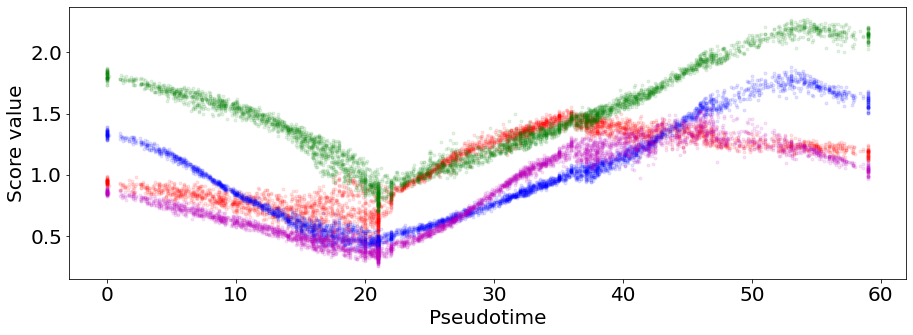

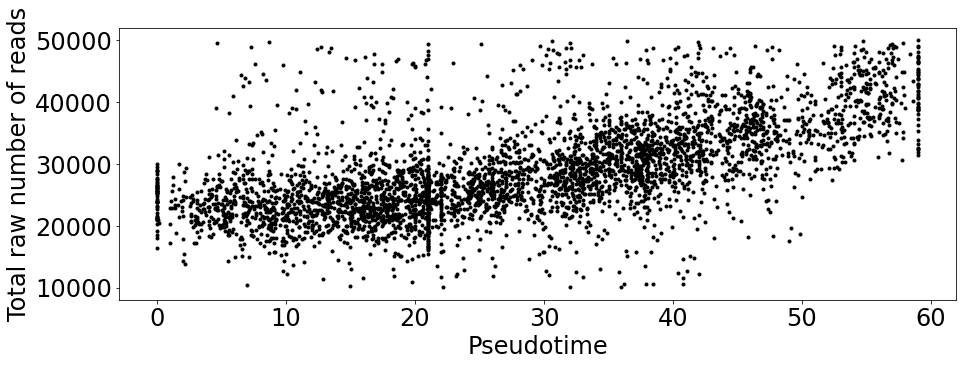

In [37]:
scores = ['S-phase','G2-M','G2-M-','Histone']
score_dict = {'S-phase':adata.uns['S-phase_genes'],'G2-M':adata.uns['G2-M_genes'],'G2-M-':adata.uns['G2-M_INH_genes'],'Histone_IC':adata.uns['Histone_IC_genes']}
#score_dict = {'S-phase':adata.uns['S-phase_genes'],'G2-M':adata.uns['G2-M_genes'],'G2-M-':adata.uns['G2-M_INH_genes'],'Histone_IC':adata.uns['Histone_IC_genes']}
colors = ['r','b','g','m']

plt.figure(figsize=(15,5))
_plot_scores(adata_cc,egr_final,PseudoTimeTraj_final,scores,score_dict,colors,plot_legend=False)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(PseudoTimeTraj_final[0]['Pseudotime'],adata.obs['total_counts_raw'][PseudoTimeTraj_final[0]['Points']],'k.')
plt.xlabel('Pseudotime')
plt.ylabel('Total raw number of reads')
plt.show()

(60, 30)


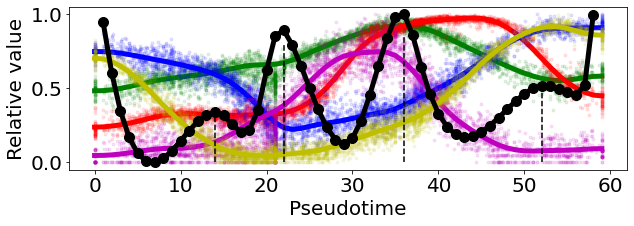

node_full (60, 621)


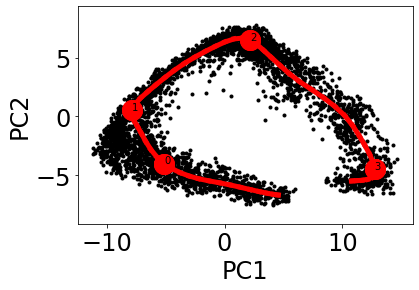

In [38]:
plt.figure(figsize=(10,3))
#genes = ['CDT1','GMNN'] #,'E2F2','E2F3','CCNE1']
#genes = ['PCNA','CCNB1']
genes = ['PCNA','H4C3','CDKN3','CCNE2','AURKA']
colors = ['g','r','b','m','y']
_plot_gene_expression(adata_cc,egr_final,PseudoTimeTraj_final,genes,colors,plot_legend=False)
#plt.show()
#plt.figure(figsize=(10,5))
curvature_peaks = _plot_curvature(adata_cc,egr_final,PseudoTimeTraj_final,scale=1.0,smoothing_factor=18)
curvature_peaks = np.array(curvature_peaks)
plt.ylabel('Relative value',fontsize=20)
plt.xlabel('Pseudotime',fontsize=20)
plt.savefig(dataset_name+'_curvature.png')
plt.show()
_plot_trajectory(adata_cc,egr_final,PseudoTimeTraj_final,curvature_peaks,i0=0,i1=1)
plt.show()


In [39]:
adata.uns['ElasticGraph_nodes'] = egr_final[0]['NodePositions']
adata.uns['ElasticGraph_edges'] = egr_final[0]['Edges'][0]
adata.uns['Trajectory'] = PseudoTimeTraj_final[0]['Trajectory']
adata.uns['Pseudotime'] = PseudoTimeTraj_final[0]['Pseudotime']
adata.uns['Points'] = PseudoTimeTraj_final[0]['Points']
adata.uns['CurvaturePeaks'] = curvature_peaks
adata.write_h5ad(folder+dataset_name+'_renorm_proc.h5ad',compression='gzip')